# SPAIN ECONOMIC POLICY UNCERTAINTY INDEX - TIME SERIES FORECASTING

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/9/9a/Flag_of_Spain.svg" width="120">
</p>


### 0. LIBRARIES

In [872]:
%%capture
%pip install plotly statsmodels scikit-learn xgboost pmdarima statsforecast arch

In [873]:
# Core Libraries
import numpy as np
import pandas as pd
import itertools
import warnings
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.patheffects as pe
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.graph_objects as go

# Time Series Analysis & Statistical Models
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import pmdarima as pm
from pmdarima.arima import auto_arima
from scipy.signal import periodogram
from scipy.fft import fft
from scipy import stats

# Volatility Models
from arch import arch_model
from statsforecast import StatsForecast
from statsforecast.models import ARCH, GARCH, Naive

# Machine Learning
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# Deep Learning (Keras/TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError

# Notebook Settings
%matplotlib inline
warnings.filterwarnings('ignore')


### 1. IMPORT DATASET

In [875]:
df = pd.read_excel("C:\Users\phath\OneDrive\DevProjects\DataScience\forecasting\spain-economics-forecasting\NEW_SPAIN_EPU_INDEX.xlsx",skiprows=1)



In [876]:
df.head() 

,Year,Month,Index value
0,1997,1,31.018169
1,1997,2,50.695080
2,1997,3,43.754341
3,1997,4,43.427864
4,1997,5,120.413849


In [877]:
df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))
df = df.set_index('Date').sort_index()
df = df.reset_index()
df = df.drop(columns="Year")
df.tail(12)

,Date,Month,Index value
328,2024-05-01,5,187.389099
329,2024-06-01,6,151.781204
330,2024-07-01,7,128.468445
331,2024-08-01,8,159.060776
332,2024-09-01,9,148.101639
333,2024-10-01,10,156.164917
334,2024-11-01,11,180.674820
335,2024-12-01,12,180.977631
336,2025-01-01,1,191.908890
337,2025-02-01,2,147.651108


### 2. EXPLORY DATA ANALYSIS

In [879]:
df.info()

df.isnull().sum()

df.duplicated().sum()

df.nunique().values

df.count().values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         340 non-null    datetime64[ns]
 1   Month        340 non-null    int64         
 2   Index value  340 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 8.1 KB


,Date,Month,Index value
count,340,340.000000,340.000000
mean,2011-02-15 02:07:03.529411840,6.452941,112.745058
min,1997-01-01 00:00:00,1.000000,31.018169
25%,2004-01-24 06:00:00,3.000000,80.984438
50%,2011-02-15 00:00:00,6.000000,108.462086
75%,2018-03-08 18:00:00,9.000000,140.231647
max,2025-04-01 00:00:00,12.000000,261.609741
std,NaN,3.465909,40.348093


In [883]:
print("Data shape: ", df.shape)
print(f"Total observations: {len(df)}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Data shape:  (340, 3)
Total observations: 340
Date range: 1997-01-01 00:00:00 to 2025-04-01 00:00:00


To avoid unwant inplace to default dataset, we copy another df name: eda_df

In [885]:
eda_df = df.copy() #edadatase
eda_df.head()

,Date,Month,Index value
0,1997-01-01,1,31.018169
1,1997-02-01,2,50.695080
2,1997-03-01,3,43.754341
3,1997-04-01,4,43.427864
4,1997-05-01,5,120.413849


--- 
Plotting the EPU Index over time reveals its evolution from 1997 through 2025. Early years show relatively stable and moderate uncertainty levels. Over time, pronounced peaks appear, reflecting periods of intensified economic or political stress. Especially noticeable are sharp increases around 2012 and 2020, aligning with known global and regional crises. This visualization helps us understand the overall trend and long-term shifts in economic policy uncertainty in Spain.

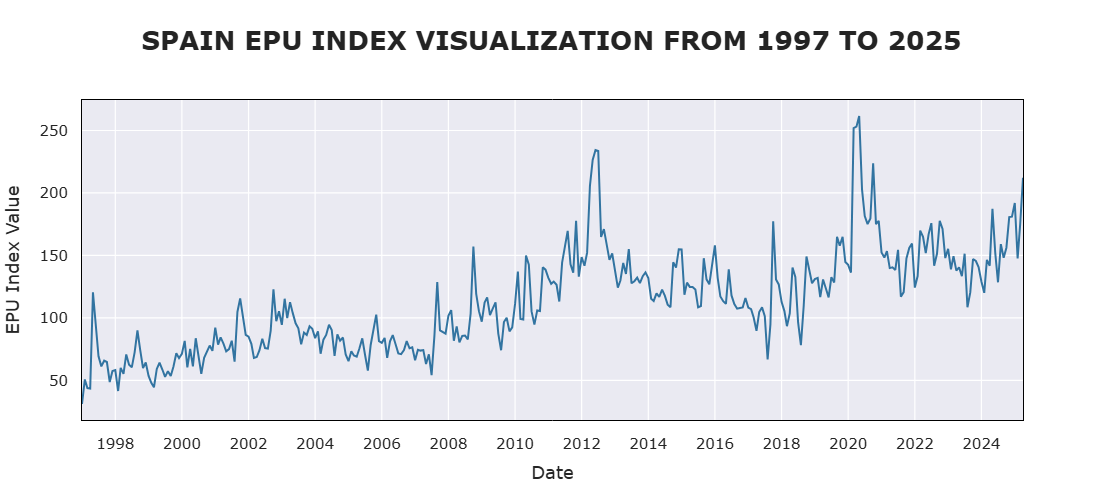

In [887]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['Date'],
    y=df['Index value'],
    mode='lines',
    name='EPU Index',
    line=dict(color="#3274a1", width=2),
))

fig.update_layout(
    title=dict(
        text='<b>SPAIN EPU INDEX VISUALIZATION FROM 1997 TO 2025</b>',
        x=0.5,
        font=dict(size=26)
    ),
    xaxis_title='Date',
    yaxis_title='EPU Index Value',
    width=1100,
    height=500,
    template='seaborn',
    font=dict(size=15),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1,
        font=dict(size=15)
    )
)

fig.update_xaxes(
    showgrid=True,
    gridwidth=1.2,
    dtick="M24",
    tickformat="%Y",
    showline=True,
    linewidth=1,
    linecolor='black',
    mirror=True,
    ticklabelstandoff=10 
)

fig.update_yaxes(
    showgrid=True,
    gridwidth=1.2,
    zeroline=True,
    zerolinewidth=1.5,
    showline=True,
    linewidth=1,
    linecolor='black',
    mirror=True,
    ticklabelstandoff=10
)


fig.show()


---
To better capture underlying trends, we apply a 12-month rolling average. This smoothed view highlights periods of sustained high uncertainty. Notably, while short-term fluctuations abound, there is a clear upward drift in the smoothed curve over the years. This suggests that baseline economic policy uncertainty in Spain has gradually increased, moving from lower values in the early 2000s to consistently elevated levels in the 2010s and 2020s.


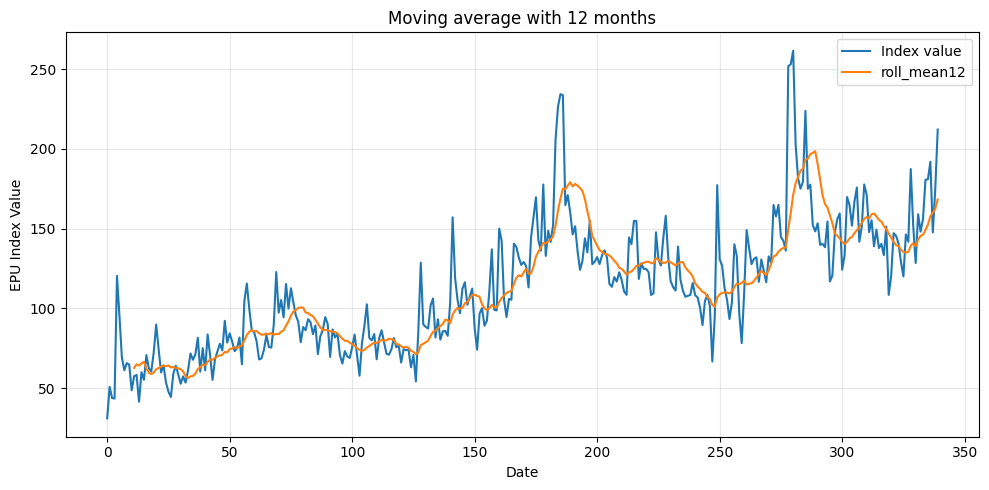

In [889]:
colors = ['#2f4b7c', '#ff7c43']
eda_df["roll_mean12"] = eda_df["Index value"].rolling(12).mean()
eda_df[['Index value', 'roll_mean12']].plot(
    figsize=(10, 5),
    linewidth=1.5,
    title="Moving average with 12 months"
)

plt.grid(alpha=0.3)
plt.xlabel("Date")
plt.ylabel("EPU Index Value")
plt.tight_layout()
plt.show()

--- 
Examining the distribution of the EPU Index shows a right-skewed shape, with most observations clustering between 50 and 150 but with a long tail of high values. This confirms that while moderate uncertainty is typical, there are occasional extreme events driving the index to much higher levels. Understanding this skew is important for modeling and forecasting, as these rare but impactful spikes can heavily influence mean values and volatility. 

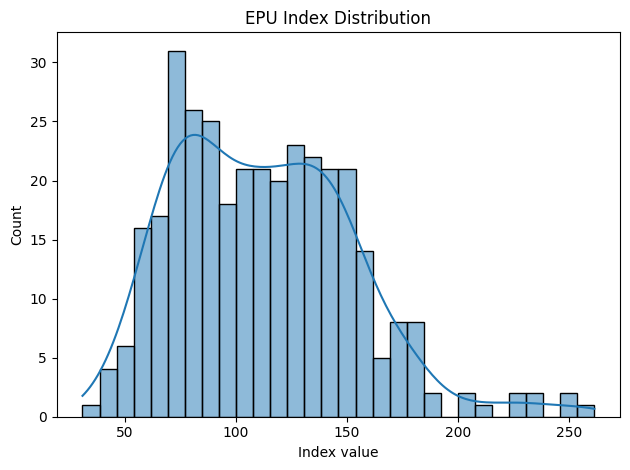

In [891]:
sns.histplot(
    eda_df['Index value'],
    bins=30,
    kde=True,
)

plt.title("EPU Index Distribution")
plt.tight_layout()
plt.show()


In general:
- Wide, multi-modal distribution with mild left-skew.
- Most values ~80–150 but some very high outliers.
- Suggests different regimes and crisis periods.
- Modeling should account for variability and outliers.

--- 
A box plot further illustrates the distribution's spread and highlights the presence of outliers. Most values lie below approximately 220, with clear outlier points beyond this threshold. These outliers reflect periods of exceptional economic policy uncertainty that could strongly influence forecasting models. Identifying and managing these points is essential in preprocessing and modeling phases.

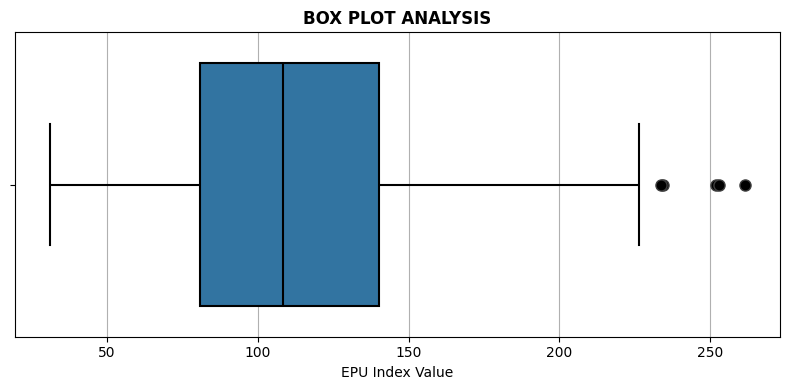

5th percentile: 58.21
10th percentile: 65.65
25th percentile: 80.98
50th percentile: 108.46
75th percentile: 140.23
90th percentile: 159.63
95th percentile: 177.71


In [894]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    x=eda_df['Index value'],
    orient='h',
    boxprops=dict(edgecolor="black", linewidth=1.5),
    medianprops=dict(color='black', linewidth=1.5),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    flierprops=dict(markerfacecolor='black', marker='o', markersize=8, linestyle='none')
)

plt.title("BOX PLOT ANALYSIS", fontweight='bold')
plt.xlabel("EPU Index Value")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

percentiles = [5, 10, 25, 50, 75, 90, 95]
for p in percentiles:
    value = np.percentile(df['Index value'], p) 
    print(f"{p}th percentile: {value:.2f}")


**Why are there outliers in the Spain EPU Index?**

- They reflect real events (not noise).
- Driven by crises: 2008 Financial Crisis, Euro Debt Crisis, COVID-19, Ukraine-Russia War.
- Show sharp jumps in policy uncertainty during extreme shocks.
- Important signals for forecasting and risk analysis.

**With all the crise can be illustrated by the crisis chart and outliers point chart below**

---
We further annotate the time series with shaded bands for key crisis periods: the 2008 Financial Crisis, European Debt Crisis, COVID-19 Pandemic, and Ukraine-Russia War. These visual markers help link observed index spikes with real-world events. By mapping crises onto the index, we see clear patterns of heightened uncertainty during global and regional shocks. This context is vital for interpreting model forecasts and potential policy responses.

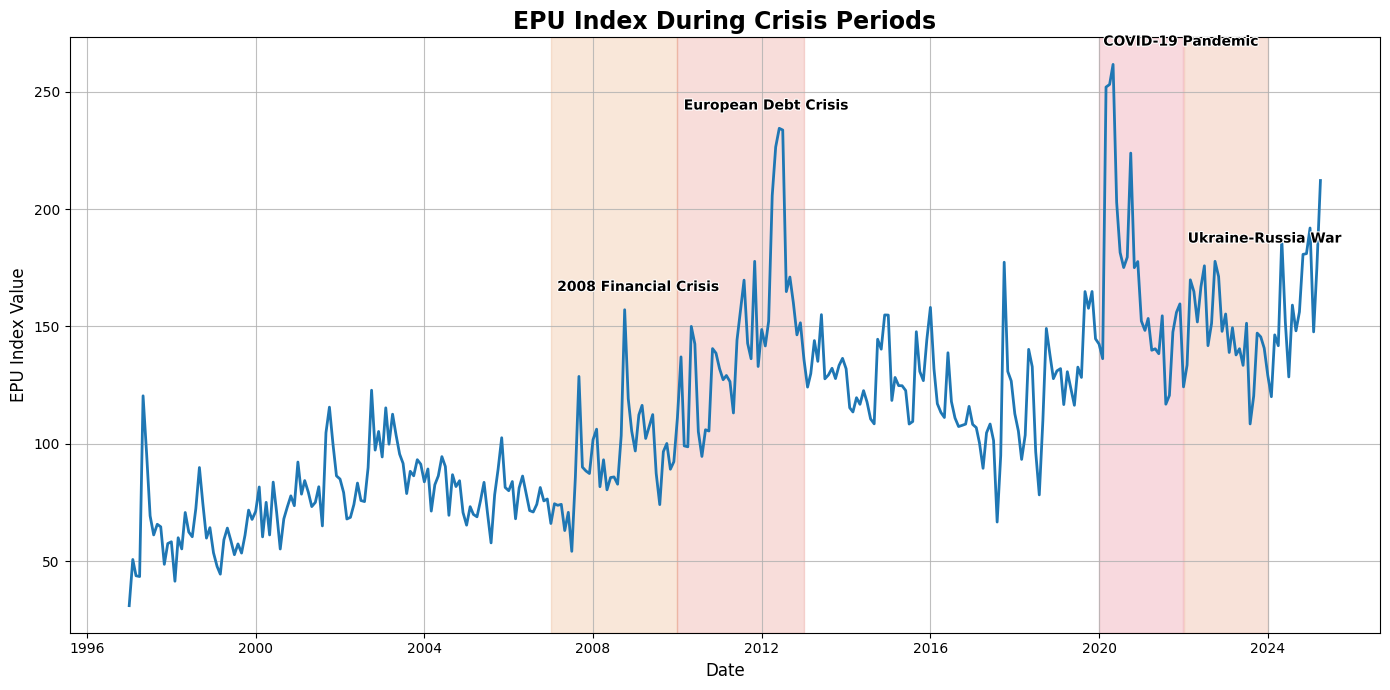

In [897]:
crisis_periods = {
    '2008 Financial Crisis': ('2007-01-01', '2009-12-31'),
    'European Debt Crisis': ('2010-01-01', '2012-12-31'),
    'COVID-19 Pandemic': ('2020-01-01', '2021-12-31'),
    'Ukraine-Russia War': ('2022-01-01', '2023-12-31')
}
highlight_colors = ["#e18745", "#dc574a", "#de425b", "#e06f45"]

plt.figure(figsize=(14, 7))


plt.plot(eda_df['Date'], eda_df['Index value'], linewidth=2,
         label="EPU Index", zorder=3)

for i, (crisis, (start, end)) in enumerate(crisis_periods.items()):
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    crisis_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    if not crisis_data.empty:
        plt.axvspan(
            start_date, end_date,
            color=highlight_colors[i],
            alpha=0.2,  
        )
        plt.text(
            x=start_date + (end_date - start_date) / 20,
            y=crisis_data['Index value'].max() + 8,
            s=crisis,
            fontsize=10,
            fontweight='bold',
            path_effects=[pe.withStroke(linewidth=1.5, foreground="white")]
        )
plt.title("EPU Index During Crisis Periods", fontsize=17, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("EPU Index Value", fontsize=12)
plt.grid(alpha=0.8)
plt.tight_layout()
plt.show()


We explicitly identify outlier points above the upper interquartile threshold (using 1.5*IQR). Plotting these on the time series reveals that outliers correspond to major crisis periods. For example, spikes around 2012 and 2020 are visually highlighted, aligning with the European Debt Crisis and the COVID-19 Pandemic. This step is crucial in understanding model behavior and informing robust preprocessing strategies.

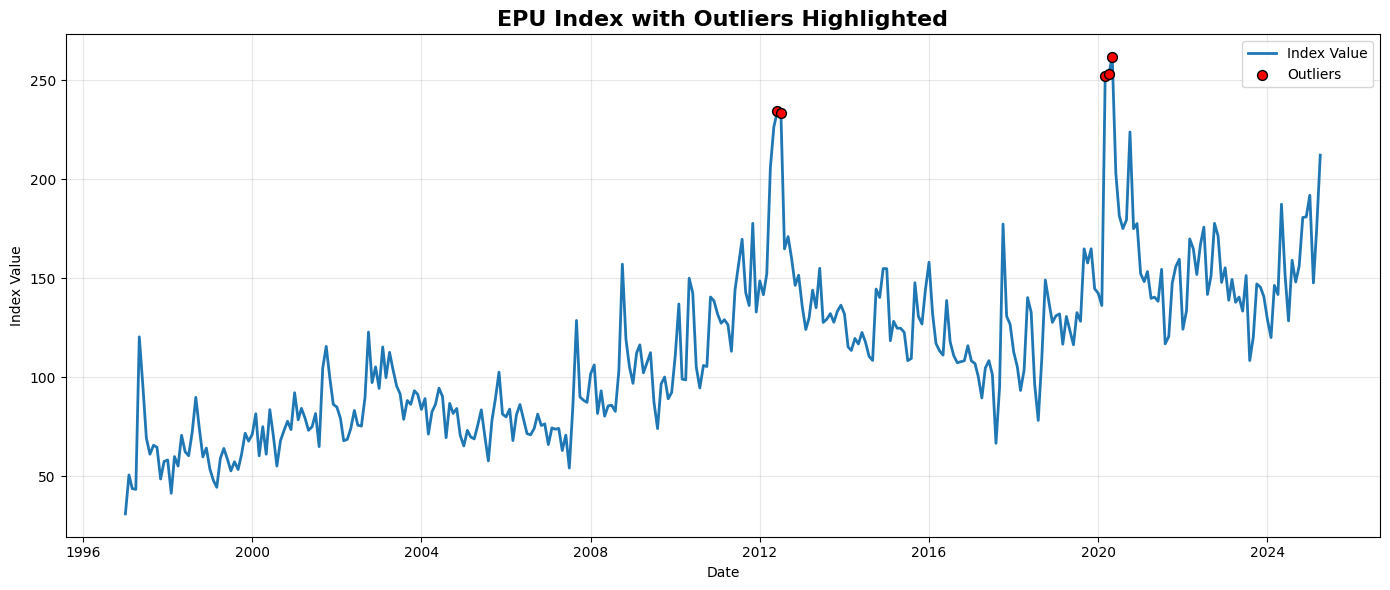

In [899]:
q1 = eda_df['Index value'].quantile(0.25)
q3 = eda_df['Index value'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr

outliers = eda_df[eda_df['Index value'] > upper]
plt.figure(figsize=(14, 6))
plt.plot(
    eda_df['Date'], eda_df['Index value'], linewidth=2, label='Index Value'
)
plt.scatter(
    outliers['Date'], outliers['Index value'],
    color="red", edgecolor='black', s=50, zorder=4, label='Outliers'
)
plt.title('EPU Index with Outliers Highlighted', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


---
Also, a violin plot compares EPU Index distributions across decades. The 1990s and 2000s show tighter, lower-centered distributions, suggesting relatively stable and moderate uncertainty. In contrast, the 2010s and 2020s exhibit broader spreads and higher medians, reflecting increased uncertainty and more frequent extreme values. This progression underscores how Spain's economic policy environment has become more volatile over time, and it highlights the importance of using models capable of capturing these structural shifts.

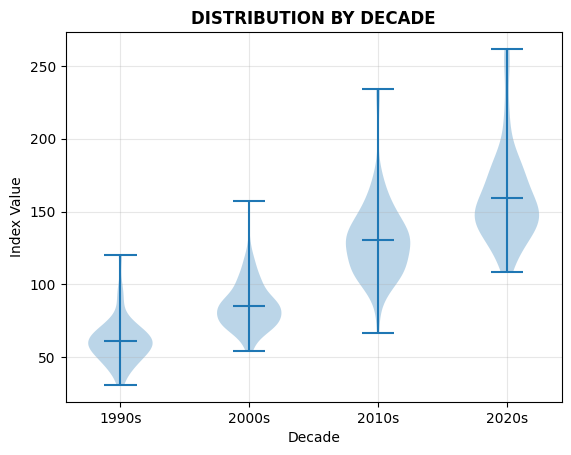

In [901]:
eda_df['Year'] = eda_df['Date'].dt.year
eda_df['Decade'] = (eda_df['Year'] // 10) * 10
decades = sorted(eda_df['Decade'].unique())
decade_data = [eda_df[eda_df['Decade'] == d]['Index value'] for d in decades]
violin_parts = plt.violinplot(decade_data, positions=range(len(decades)), showmeans=True)
plt.xticks(range(len(decades)))
plt.xticks(range(len(decades)), [f"{int(d)}s" for d in decades])
plt.title('DISTRIBUTION BY DECADE', fontweight='bold')
plt.xlabel('Decade')
plt.ylabel('Index Value')
plt.grid(True, alpha=0.3)
plt.show();

To explore intra-year seasonality, we analyze average EPU Index values by month. The bar chart reveals a clear pattern: uncertainty tends to be slightly lower during summer months like July and August, and higher during autumn, with October peaking at over 123 on average. This suggests that policy uncertainty in Spain is not uniformly distributed throughout the year but shows systematic seasonal variations. These cyclical effects can be important features for forecasting models, as they reflect regular economic rhythms tied to legislative cycles, budgeting periods, or business activity.

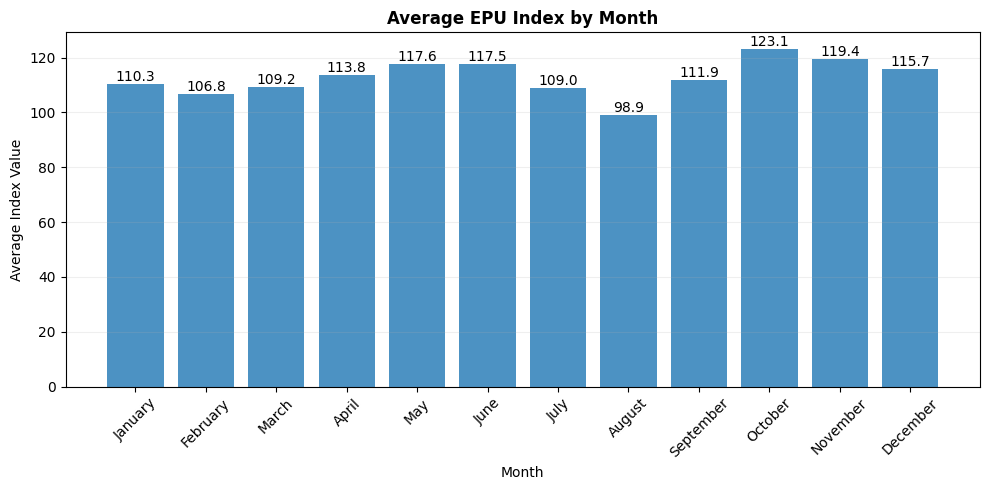

In [903]:
eda_df['Month'] = eda_df['Date'].dt.month
eda_df['Month_Name'] = eda_df['Date'].dt.month_name()

monthly_stats = eda_df.groupby('Month').agg(mean=('Index value', 'mean'), std=('Index value', 'std')).reset_index()
monthly_stats['Month_Name'] = pd.to_datetime(monthly_stats['Month'], format='%m').dt.month_name()

plt.figure(figsize=(10, 5))
bars = plt.bar(monthly_stats['Month_Name'], monthly_stats['mean'], alpha=0.8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.title('Average EPU Index by Month', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Index Value')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha = 0.2)
plt.tight_layout()
plt.show()


---

After examining monthly seasonality, we turn to quarterly averages to confirm broader patterns in Spain's Economic Policy Uncertainty. The chart of average EPU Index by quarter reinforces our previous observations: Q3 consistently shows the lowest uncertainty (around 106), while Q4 peaks at nearly 120.

This seasonal behavior aligns with typical economic cycles—summer months (Q3) often see reduced political activity and fewer major announcements, while year-end (Q4) is marked by budget approvals and policy planning, heightening uncertainty. 

Recognizing these quarterly patterns is essential for modeling, as it captures systematic fluctuations that can improve forecast accuracy. Including quarterly seasonality terms or time-based dummy variables in statistical and machine learning models can help anticipate these predictable variations, reducing forecast error and supporting better decision-making for policymakers and businesses alike.


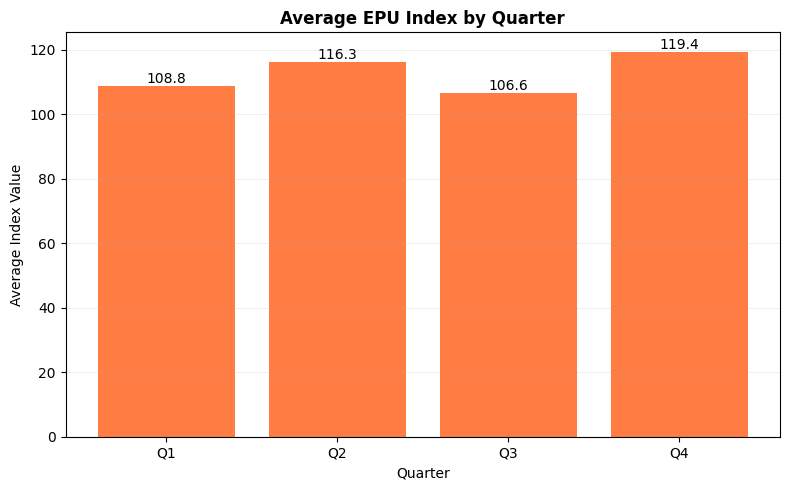

In [905]:
eda_df['Quarter'] = eda_df['Date'].dt.quarter
quarterly_stats = eda_df.groupby('Quarter')['Index value'].mean().reset_index()

plt.figure(figsize=(8, 5))
bars = plt.bar(quarterly_stats['Quarter'], quarterly_stats['Index value'], color='#ff7c43')

# Annotate
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.title('Average EPU Index by Quarter', fontweight='bold')
plt.xlabel('Quarter')
plt.ylabel('Average Index Value')
plt.xticks([1, 2, 3, 4], ['Q1', 'Q2', 'Q3', 'Q4'])
plt.grid(True, axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

---

Following the year-over-year change analysis, the 12-month rolling volatility chart offers another key perspective on Spain's EPU Index. It shows periods of heightened uncertainty, especially during major crises like 2008, the European Debt Crisis, and COVID-19.

These spikes highlight not only increases in the index level but also in its variability—important for modeling since volatility can shift dramatically over time. This insight supports the use of models like ARCH/GARCH and justifies including rolling standard deviation as a feature to help capture changing risk and improve forecast robustness.

Together, this volatility view complements our earlier trend and seasonality analyses, giving us a more complete picture for effective predictive modeling.


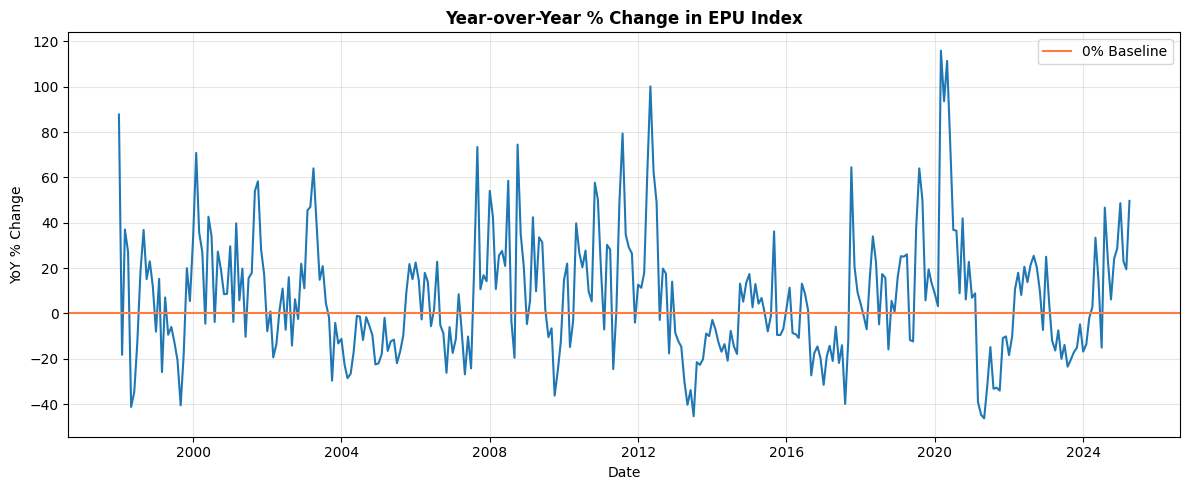

In [907]:
df_sorted = eda_df.sort_values(by='Date').copy()
df_sorted['YoY_Change'] = df_sorted['Index value'].pct_change(periods=12) * 100

plt.figure(figsize=(12, 5))
plt.plot(df_sorted['Date'], df_sorted['YoY_Change'], linewidth=1.5)
plt.axhline(0, color='#ff7c43', linestyle='-', label='0% Baseline')
plt.title('Year-over-Year % Change in EPU Index', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('YoY % Change')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


---

The 12-month rolling volatility chart refines our view of the EPU Index by tracking its changing variability over time. Noticeable peaks align with major crises, reinforcing the idea that uncertainty isn't constant but clustered in volatile periods.

This emphasizes the value of volatility features and models that can adapt to such shifts, supporting better forecasting and risk management.



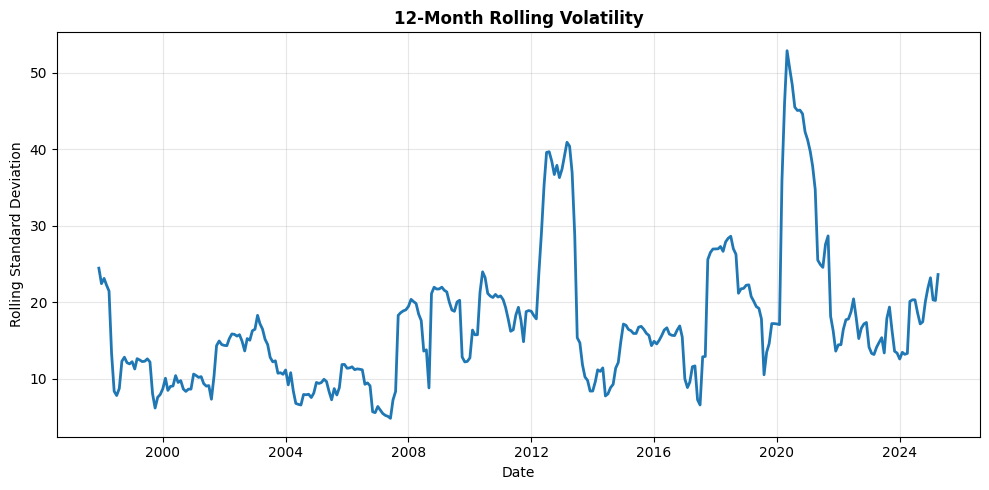

In [909]:
rolling_vol = eda_df.set_index('Date')['Index value'].rolling(window=12).std()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(rolling_vol.index, rolling_vol.values, linewidth=2)

ax.set_title('12-Month Rolling Volatility', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Rolling Standard Deviation')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---

The heatmap shows strong autocorrelations for short-term lags like 1 and 2, as well as 6 and 12 months. These lags capture both immediate and seasonal dependencies, guiding feature selection for time series models.

<Axes: >

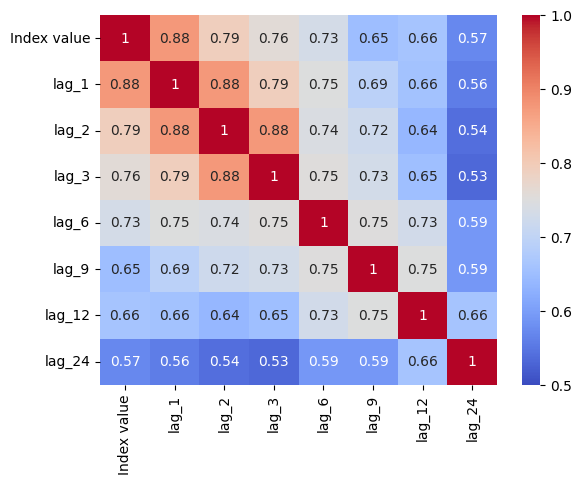

In [911]:
for lag in [1, 2, 3, 6, 9, 12, 24]:
    eda_df[f'lag_{lag}'] = eda_df['Index value'].shift(lag)
corr = eda_df[['Index value', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_9', 'lag_12', 'lag_24']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=0.5)

---
This heatmap continues the story of strong seasonality seen in the monthly and quarterly bar charts. It shows monthly EPU values across years, highlighting not only crisis spikes but also recurring seasonal patterns. These visible monthly cycles reinforce why incorporating month as a feature or seasonal terms in models like SARIMA is crucial for capturing EPU's temporal dynamics.

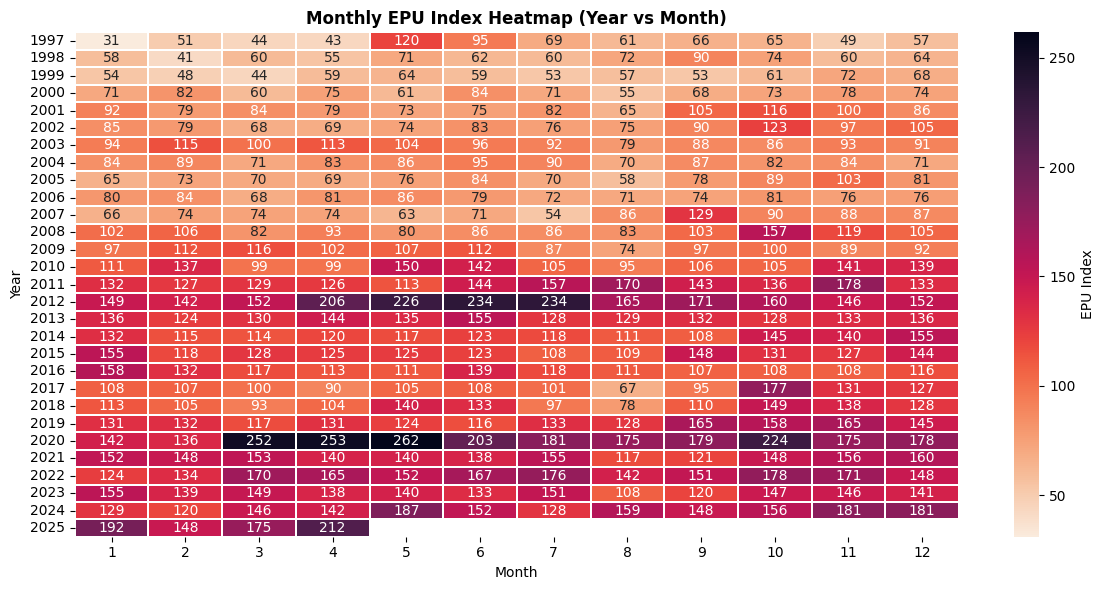

In [913]:
pivot = df.pivot_table(
    index=df['Date'].dt.year,
    columns=df['Date'].dt.month,
    values='Index value',
    aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="rocket_r", annot=True, fmt=".0f", linewidths=0.3, cbar_kws={'label': 'EPU Index'})
plt.title("Monthly EPU Index Heatmap (Year vs Month)", fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


In [914]:
def check_stationarity(series, p_significant=0.05):
    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [915]:
check_stationarity(df["Index value"])

ADF Statistic : -1.52967, p-value: 0.51879
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
KPSS Statistic: 2.35393, p-value: 0.01000
Non-stationary


In [916]:
diff = df['Index value'].diff(1).dropna()

In [917]:
check_stationarity(diff)

ADF Statistic : -7.95110, p-value: 0.00000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
KPSS Statistic: 0.12544, p-value: 0.10000
Stationary


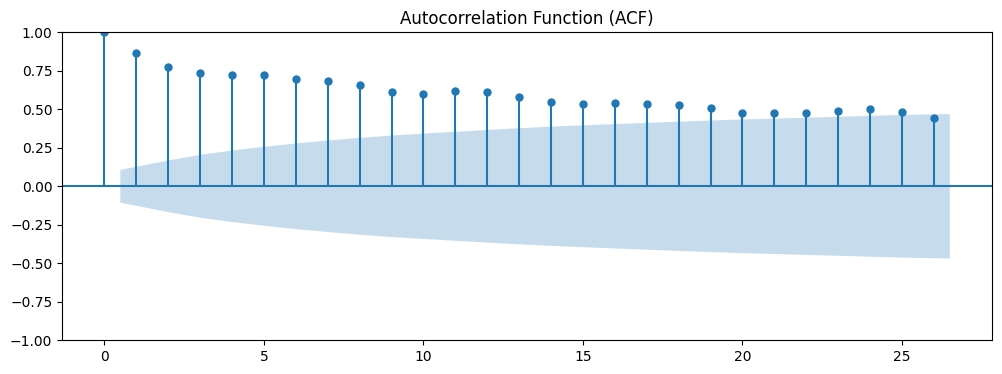

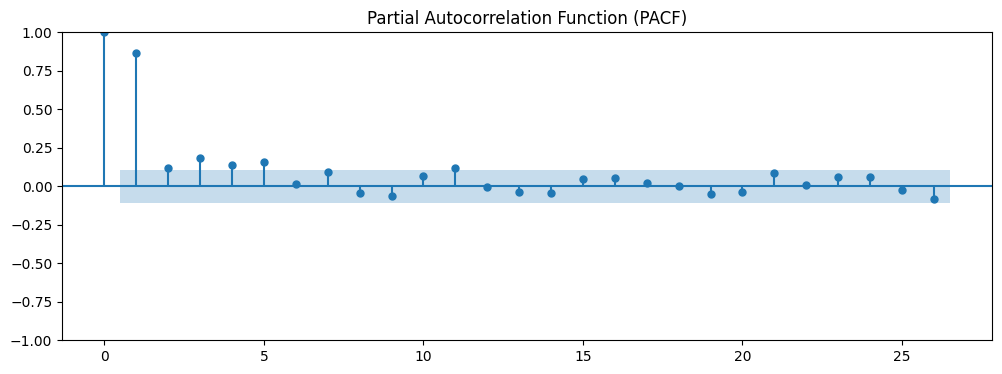

In [918]:
# Plot the ACF
fig_acf = plot_acf(df['Index value'], title='Autocorrelation Function (ACF)')
fig_acf.set_size_inches(12,4)
plt.show();

# Plot the PACF
fig_pacf = plot_pacf(df['Index value'], title='Partial Autocorrelation Function (PACF)')
fig_pacf.set_size_inches(12,4)
plt.show();

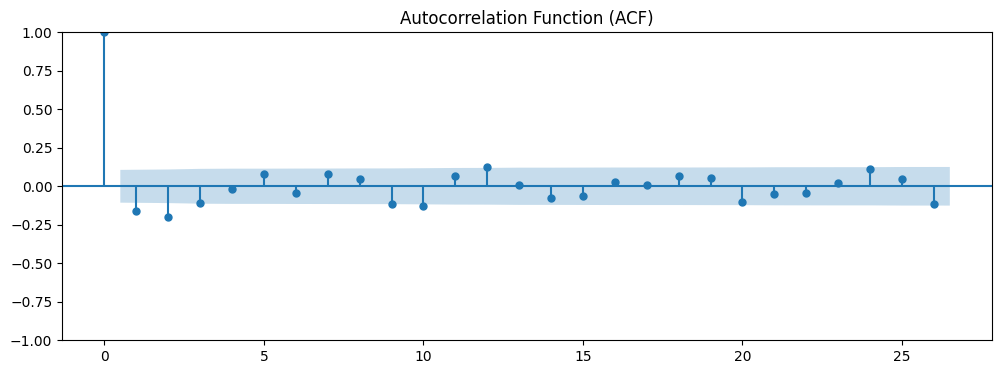

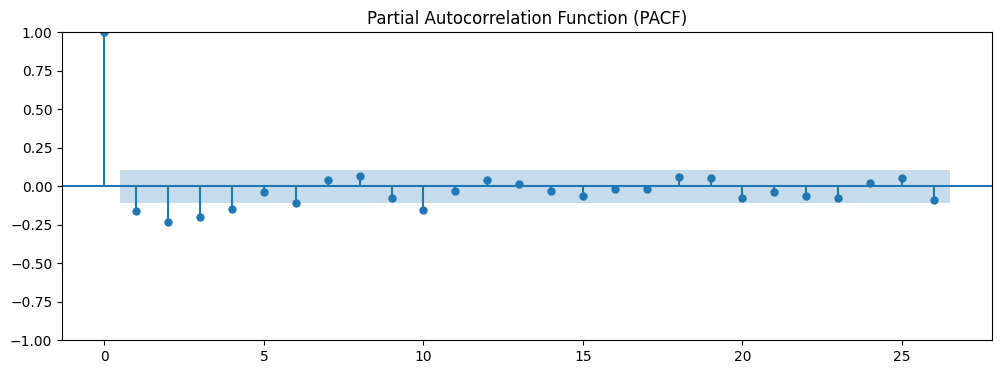

In [919]:
# Plot the ACF
fig_acf = plot_acf(diff, title='Autocorrelation Function (ACF)')
fig_acf.set_size_inches(12,4)
plt.show();

# Plot the PACF
fig_pacf = plot_pacf(diff, title='Partial Autocorrelation Function (PACF)')
fig_pacf.set_size_inches(12,4)
plt.show();


**ADF and KPSS Tests**:
  - The original EPU Index series is **non-stationary**, with clear trends and crisis-driven shifts.
  - After **first differencing**, it becomes **stationary** and shows no significant autocorrelation, making it suitable for ARIMA/SARIMA with d=1.

**ACF and PACF Analysis**:
  - Autocorrelations decline sharply after differencing.
  - No significant coefficients appear beyond lag 0, indicating a **random walk** behavior.
  - Confirms the first-differenced series is stationary and uncorrelated, simplifying choice of p and q.

**Conclusion**: These tests and plots ensure the series meets ARIMA/SARIMA assumptions, supporting more robust EPU Index forecasting.


### 3. DATA PREPROCESSING

In [922]:
df_sorted = df.sort_values('Date')
date_diff = df_sorted['Date'].diff().dt.days.dropna()

In [923]:
df['Month'] = df['Month'].astype(int)
df['Index value'] = df['Index value'].astype(float)

In [924]:
for col in df.columns:
    missing_data = df[col].isna().sum()
    missing_per = missing_data /len(df)*100
    print(f"Column {col} has {missing_per}% missing data")

Column Date has 0.0% missing data
Column Month has 0.0% missing data
Column Index value has 0.0% missing data


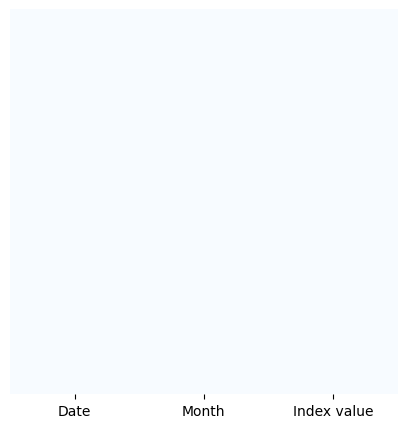

In [925]:
plt.figure(figsize = (5,5))
sns.heatmap(df.isna(), cbar = False, cmap = "Blues", yticklabels = False )
plt.show();

In [926]:
df.dropna(inplace=True)

In [927]:
test_size = 12
train = df[:-test_size]
test = df[-test_size:]
print(f"train size {train.shape}")
print(f"test size {test.shape}")

train size (328, 3)
test size (12, 3)


### 4. FEATURE ENGINEERING


In [930]:
TARGET_COLUMN = 'Index value'
DATE_COLUMN   = 'Date'
LAGS          = [1, 2, 6, 12]
WINDOWS       = [3, 6, 12]
SHOCK_EVENTS  = {
    'crisis_2012': ('2012-06-01', '2012-07-31'),
    'covid_2020':  ('2020-03-01', '2020-05-31'),
}

def create_date_features(df, date_column='Date'):
    df = df.copy()
    df[date_column] = pd.to_datetime(df[date_column])
    df['month']   = df[date_column].dt.month
    df['quarter'] = df[date_column].dt.quarter
    df['year']    = df[date_column].dt.year
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

def create_lag_features(df, target_column, lags):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    return df

def create_rolling_features(df, target_column, windows):
    df = df.copy()
    for w in windows:
        shifted = df[target_column].shift(1)
        df[f'roll_mean_{w}'] = shifted.rolling(window=w, min_periods=w).mean()
        df[f'roll_std_{w}']  = shifted.rolling(window=w, min_periods=w).std()
    return df

def create_fourier_features(df, target_column):
    df = df.copy()
    vals = df[target_column].fillna(0).values
    ft   = fft(vals)
    df['fft_real'] = np.real(ft)
    df['fft_imag'] = np.imag(ft)
    return df

def create_shock_dummies(df, date_column, shock_events):
    df = df.copy()
    dates = df[date_column]
    for name, (start, end) in shock_events.items():
        mask = (dates >= pd.to_datetime(start)) & (dates <= pd.to_datetime(end))
        df[name] = mask.astype(int)
    return df

# ------------------------------------------
# MAIN PIPELINE FUNCTION
# ------------------------------------------
def run_epu_feature_pipeline(
    df,
    target_column=TARGET_COLUMN,
    date_column=DATE_COLUMN,
    lags=LAGS,
    windows=WINDOWS,
    shock_events=SHOCK_EVENTS
):
    df = df.copy()
    
    # Make sure date column is there
    if date_column not in df.columns:
        df = df.reset_index()
    
    df = create_date_features(df, date_column)
    df = create_lag_features(df, target_column, lags)
    df = create_rolling_features(df, target_column, windows)
    df = create_fourier_features(df, target_column)
    df = create_shock_dummies(df, date_column, shock_events)
    
    return df


In [931]:
pipeline = EPUFeaturePipeline(target_column='Index value')
fe_df = pipeline.run_pipeline(df)

In [932]:
fe_df.head()

,Date,Month,Index value,month,quarter,year,sin_month,cos_month,lag_1,lag_2,...,roll_mean_3,roll_std_3,roll_mean_6,roll_std_6,roll_mean_12,roll_std_12,fft_real,fft_imag,crisis_2012,covid_2020
0,1997-01-01,1,31.018169,1,1,1997,0.500000,8.660254e-01,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,38333.319786,-0.000000,0,0
1,1997-02-01,2,50.695080,2,1,1997,0.866025,5.000000e-01,31.018169,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-848.930783,5946.762433,0,0
2,1997-03-01,3,43.754341,3,1,1997,1.000000,6.123234e-17,50.695080,31.018169,...,NaN,NaN,NaN,NaN,NaN,NaN,1282.251094,2039.467416,0,0
3,1997-04-01,4,43.427864,4,2,1997,0.866025,-5.000000e-01,43.754341,50.695080,...,41.822530,9.979685,NaN,NaN,NaN,NaN,-2525.005739,3287.850575,0,0
4,1997-05-01,5,120.413849,5,2,1997,0.500000,-8.660254e-01,43.427864,43.754341,...,45.959095,4.104730,NaN,NaN,NaN,NaN,229.739352,188.672434,0,0


### 5. MODELLING

#### 5.1. BASELINE AND DECOMPOSITION

##### 5.1.1. TIME SERIES DECOMPOSITION

In [936]:
series = df["Index value"]

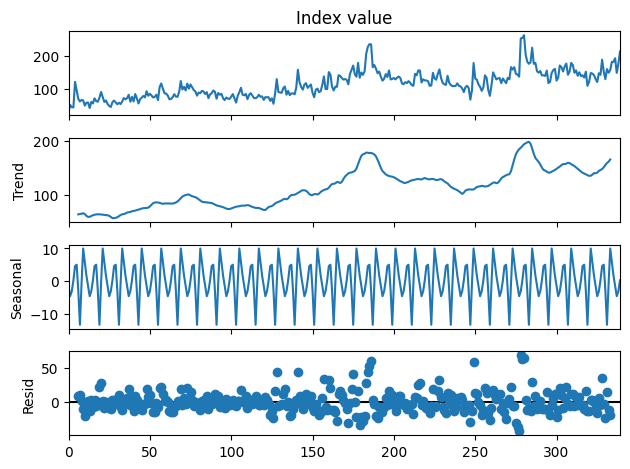

In [937]:
result_add = seasonal_decompose(series, model="additive", period=12)
result_add.plot();

**Additive** Seasonality component has roughly constant amplitude over time.

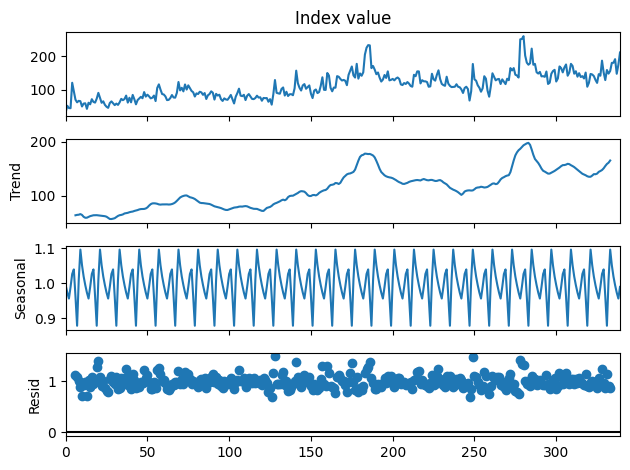

In [939]:
results_multi = seasonal_decompose(series, model="multiplicative", period=12)
results_multi.plot();

One the other hand, **Multiplicative**: seasonality scales with the overall level of the index.

In [941]:
seasonal_add = result_add.seasonal
seasonal_multi = results_multi.seasonal

<Axes: ylabel='seasonal'>

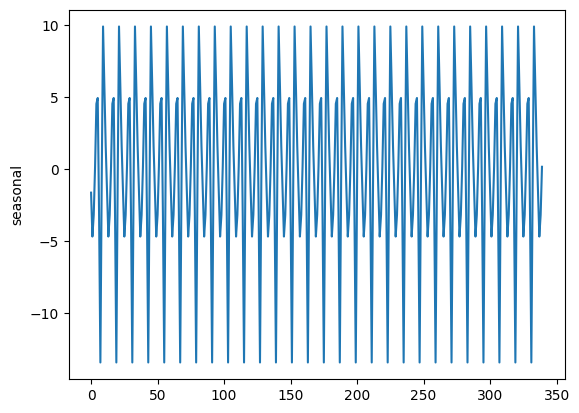

In [942]:
sns.lineplot(seasonal_add)

<Axes: ylabel='seasonal'>

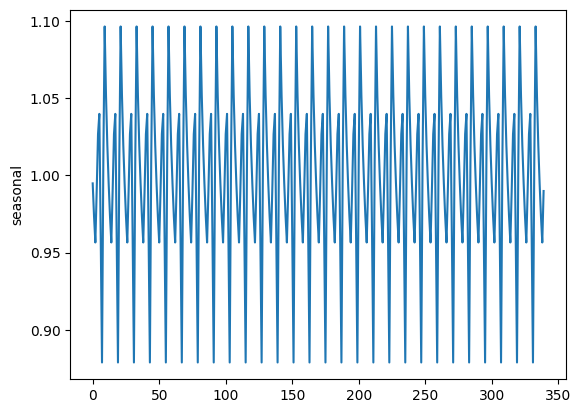

In [943]:
sns.lineplot(seasonal_multi)

##### 5.1.2. STL FORECASTING

In [946]:
df['Date'] = pd.to_datetime(df['Date'])
series = df.set_index('Date')['Index value'].asfreq('MS').interpolate()
train = series[:-12]
test = series[-12:]
print(train.index.freq)


<MonthBegin>


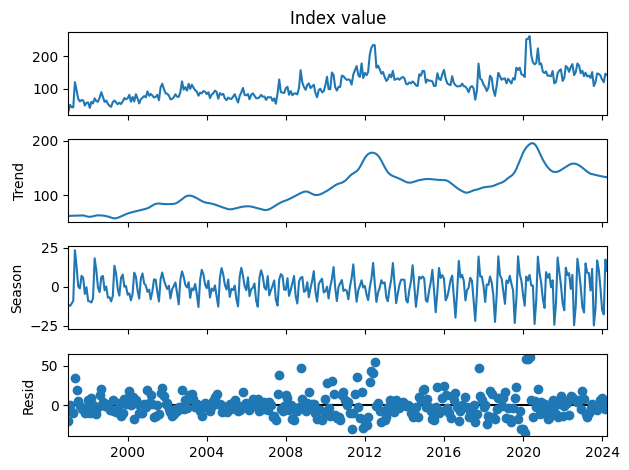

In [947]:
stl = STL(train_data, seasonal=13)
result = stl.fit()
result.plot()
plt.show()


In [948]:
deseasonalized = train_data - result.seasonal

In [949]:
model = auto_arima(deseasonalized, seasonal=False, suppress_warnings=True)
model.fit(deseasonalized)
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  328
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1357.342
Date:                Mon, 30 Jun 2025   AIC                           2720.684
Time:                        11:14:32   BIC                           2732.054
Sample:                    01-01-1997   HQIC                          2725.221
                         - 04-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5763      0.080      7.202      0.000       0.419       0.733
ma.L1         -0.8447      0.052    -16.160      0.000      -0.947      -0.742
sigma2       235.7782      9.563     24.655      0.0

In [950]:
forecast_deseasonal = model.predict(n_periods=test_size)

In [951]:
def forecast_seasonal_component(result, steps, seasonal_period):
    seasonal_component = np.tile(result.seasonal[-seasonal_period:], steps // seasonal_period)
    if steps % seasonal_period:
        seasonal_component = np.concatenate([seasonal_component, result.seasonal[-seasonal_period: -seasonal_period + steps % seasonal_period]])
    return seasonal_component[:steps]

seasonal_forecast = forecast_seasonal_component(result, test_size, 12)

In [952]:
final_forecast = forecast_deseasonal + seasonal_forecast
final_forecast = pd.Series(final_forecast, index=test_data.index, name='Forecast')

mae = mean_absolute_error(test_data, final_forecast)
rmse = np.sqrt(mean_squared_error(test_data, final_forecast))
mse = mean_squared_error(test_data, final_forecast)
mape = mean_absolute_percentage_error(test_data, final_forecast)

print(f"RMSE  : {rmse:.2f}")
print(f"MSE : {mse:.2f}")
print(f"MAE: {mae:.2%}")
print(f"MAPE : {mape:.2%}")

RMSE  : 40.77
MSE : 1661.91
MAE: 3593.08%
MAPE : 20.61%


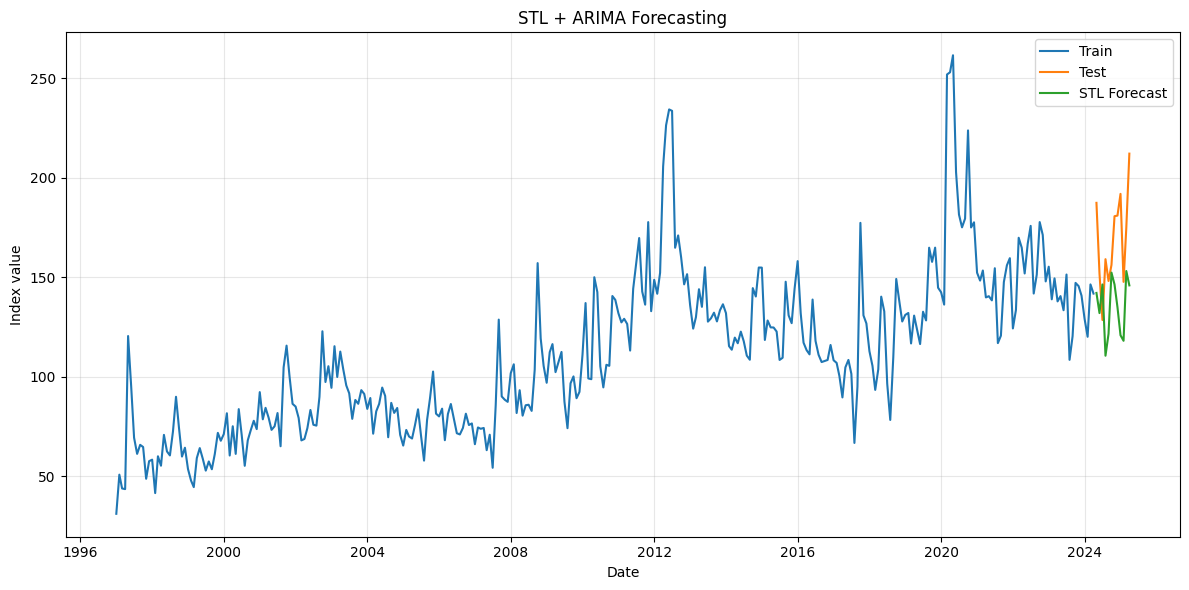

In [953]:
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(final_forecast.index, final_forecast, label='STL Forecast')
plt.title('STL + ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Index value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


##### 5.1.3. MOVING AVERAGE

Plot the original EPU Index with 3-, 6-, and 12-month moving averages. Shorter windows smooth minor noise while preserving short-term shifts. The 12-month average clearly shows the long-term upward trend, especially around crises, confirming persistent increases in baseline uncertainty over time.

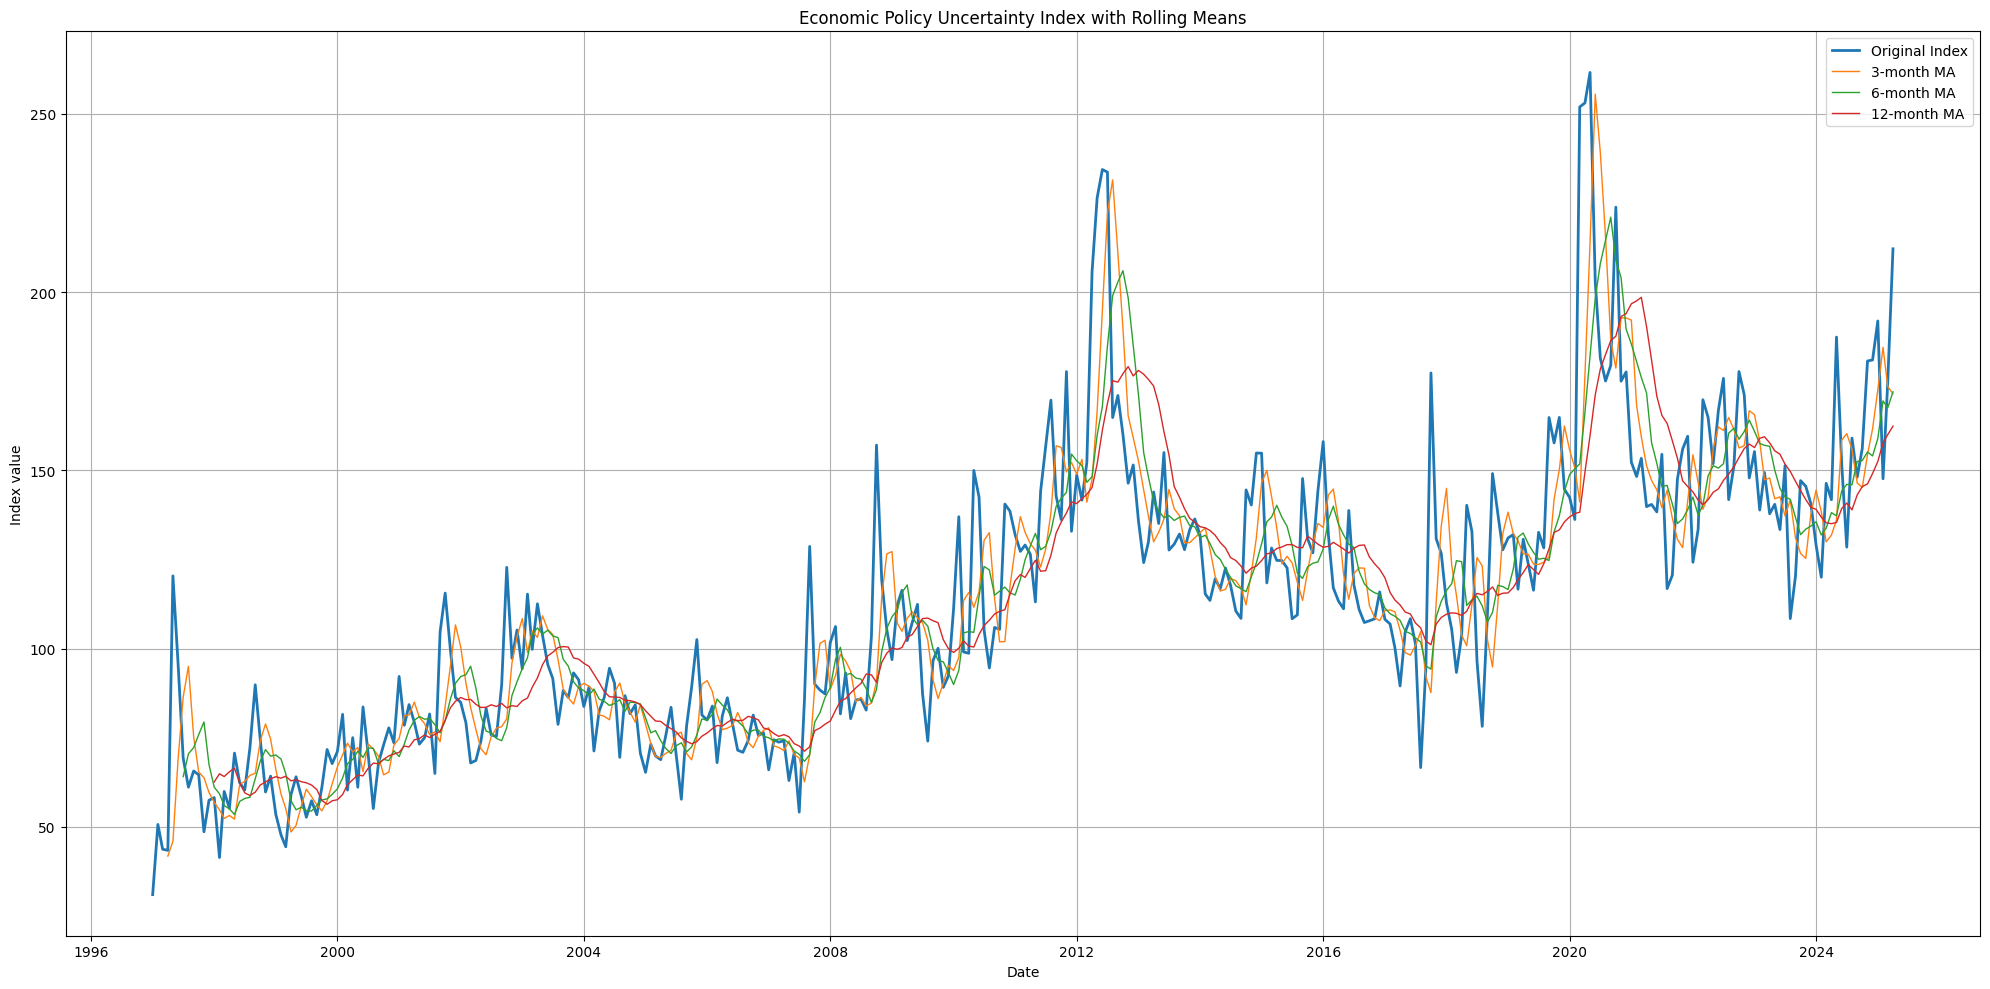

In [956]:
plt.figure(figsize=(20, 10))
plt.plot(fe_df['Date'], fe_df['Index value'], label='Original Index', linewidth=2)
plt.plot(fe_df['Date'], fe_df['roll_mean_3'], label='3-month MA', linewidth=1)
plt.plot(fe_df['Date'], fe_df['roll_mean_6'], label='6-month MA', linewidth=1)
plt.plot(fe_df['Date'], fe_df['roll_mean_12'], label='12-month MA', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Index value')
plt.title('Economic Policy Uncertainty Index with Rolling Means')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [957]:
n_test = 12

train, test = fe_df['Index value'][:-n_test], fe_df['Index value'][-n_test:]
dates_test   = fe_df['Date'][-n_test:]

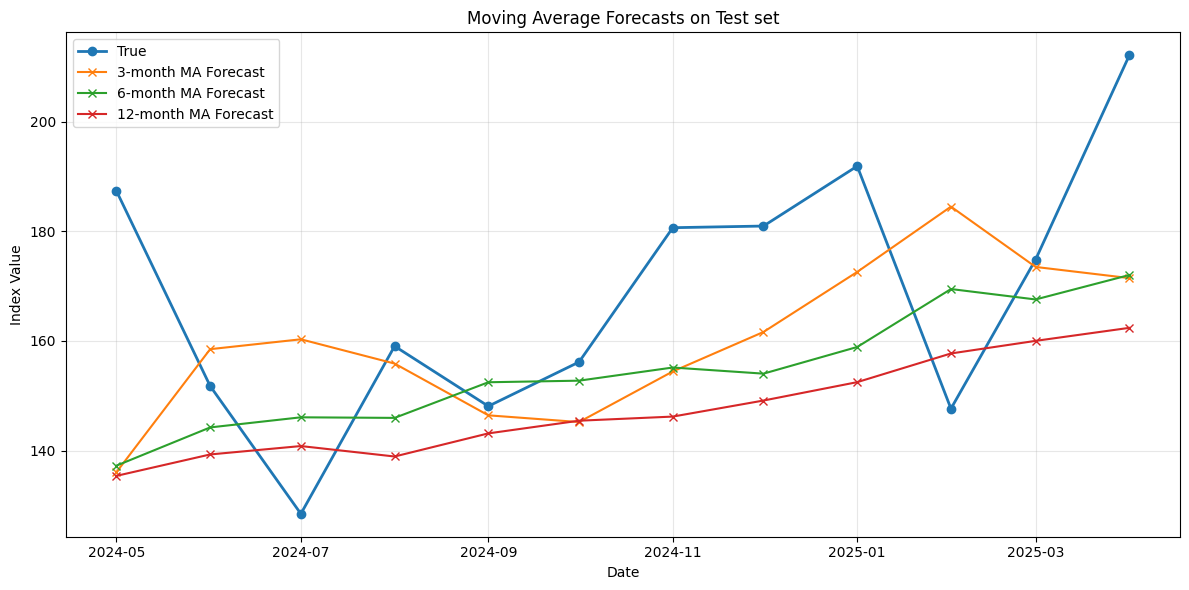

In [958]:
windows = [3, 6, 12]
preds_dict = {} 

for w in windows:
    preds = [
        fe_df['Index value'].iloc[max(0, i-w):i].mean()
        for i in range(len(train), len(train)+len(test))
    ]
    preds_dict[w] = preds

plt.figure(figsize=(12, 6))
plt.plot(dates_test, test.values, marker='o', label='True', linewidth=2)
for w in windows:
    plt.plot(dates_test, preds_dict[w], marker='x', label=f'{w}-month MA Forecast')
plt.title('Moving Average Forecasts on Test set')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [959]:
results = []
y_true = test.values
for w in [3, 6, 12]:
    # forecast
    preds = [fe_df['Index value'].iloc[max(0,i-w):i].mean()
             for i in range(len(train), len(train)+len(test))]
    y_pred = np.array(preds)

    # metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    results.append({'window': w, 'RMSE' : rmse ,'MSE': mse, 'MAE': mae, 'MAPE (%)': mape})

metrics_df = pd.DataFrame(results).set_index('window')
print('Moving average metrics:')
print(metrics_df)


Moving average metrics:
             RMSE         MSE        MAE   MAPE (%)
window                                             
3       26.261687  689.676216  20.788323  12.243745
6       25.308002  640.494979  20.902687  11.904563
12      29.024490  842.421013  24.419754  13.702740


#### 5.2. SMOOTHING MODELS

##### 5.2.1. SINGLE EXPONENTIAL SMOOTHING

In [964]:
n = len(series)
split_idx = int(0.88 * n)
train, test = series.iloc[:split_idx], series.iloc[split_idx:]

In [965]:
model = SimpleExpSmoothing(train).fit(optimized=True)
alpha = model.params['smoothing_level']
print(f"Optimal Smoothing Level (alpha): {alpha:.3f}")

Optimal Smoothing Level (alpha): 0.700


In [966]:
forecast = model.forecast(len(test))

# 4. Evaluation metrics
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"SES Test MSE  : {mse:.2f}")
print(f"SES Test RMSE : {rmse:.2f}")
print(f"SES Test MAE  : {mae:.2f}")
print(f"SES Test MAPE : {mape:.2f}%")

SES Test MSE  : 454.04
SES Test RMSE : 21.31
SES Test MAE  : 16.36
SES Test MAPE : 10.75%


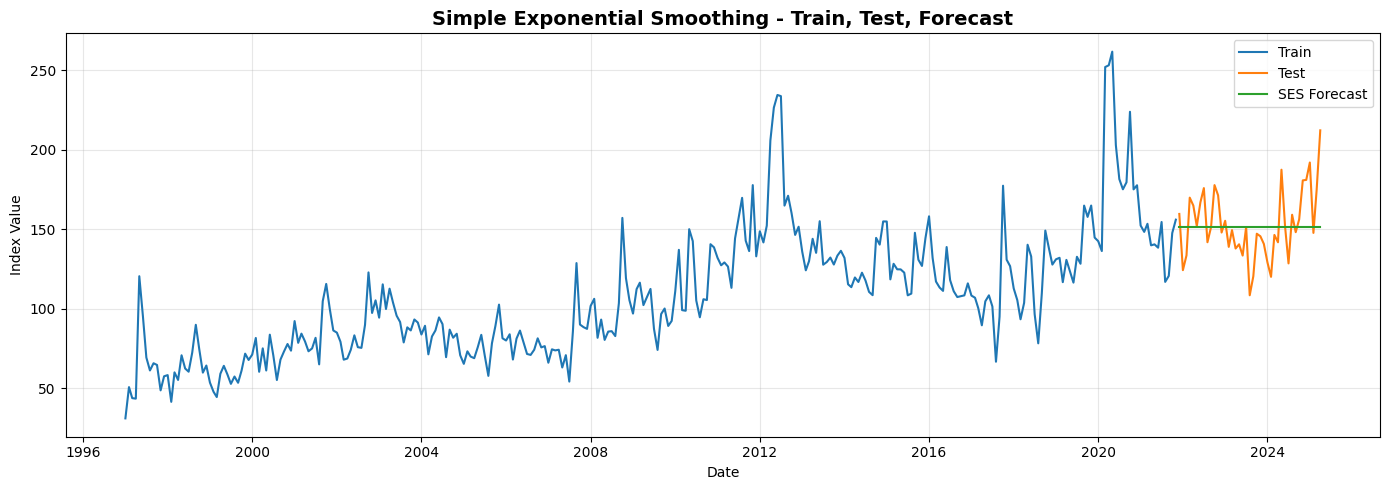

In [967]:
plt.figure(figsize=(14, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='SES Forecast')
plt.title('Simple Exponential Smoothing - Train, Test, Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Applying Simple Exponential Smoothing yields a single flat forecast line across the test period. While this approach smooths short-term noise and identifies the overall level of the series, it fails to capture the pronounced trend and strong seasonal patterns present in the EPU Index. This limitation suggests the need for more advanced methods, such as Holt-Winter linear or Holt-Winters seasonal models, which explicitly model trend and seasonality for improved forecasting accuracy.

##### 5.2.2. HOLT'S WINTER LINEAR TREND

In [970]:
holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
holt_forecast = holt_model.forecast(len(test))

In [971]:
mse_holt  = mean_squared_error(test, holt_forecast)
rmse_holt = np.sqrt(mse_holt)
mae_holt  = mean_absolute_error(test, holt_forecast)
mape_holt = np.mean(np.abs((test - holt_forecast) / test)) * 100  # (%)

print(f"Holt Linear Trend Test MSE : {mse_holt:.3f}")
print(f"Holt Linear Trend Test RMSE: {rmse_holt:.3f}")
print(f"Holt Linear Trend Test MAE : {mae_holt:.3f}")
print(f"Holt Linear Trend Test MAPE: {mape_holt:.2f}%")


Holt Linear Trend Test MSE : 440.498
Holt Linear Trend Test RMSE: 20.988
Holt Linear Trend Test MAE : 17.180
Holt Linear Trend Test MAPE: 11.62%


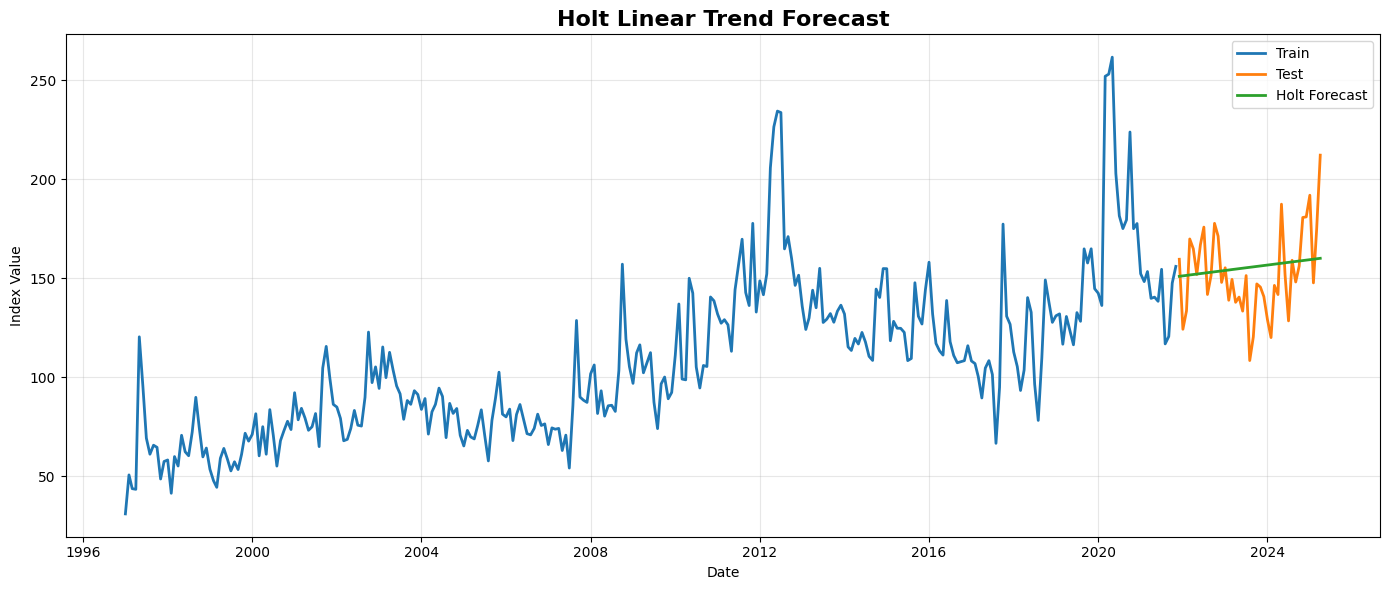

In [972]:
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Train', linewidth=2)
plt.plot(test.index, test, label='Test', linewidth=2)
plt.plot(test.index, holt_forecast, linestyle='-', label='Holt Forecast', linewidth=2)

plt.title('Holt Linear Trend Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##### 5.2.3. HOLT'S WINTER SEASONAL

In [975]:
hw_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='mul', 
    seasonal_periods=12
).fit()

In [976]:
hw_forecast = hw_model.forecast(len(test))

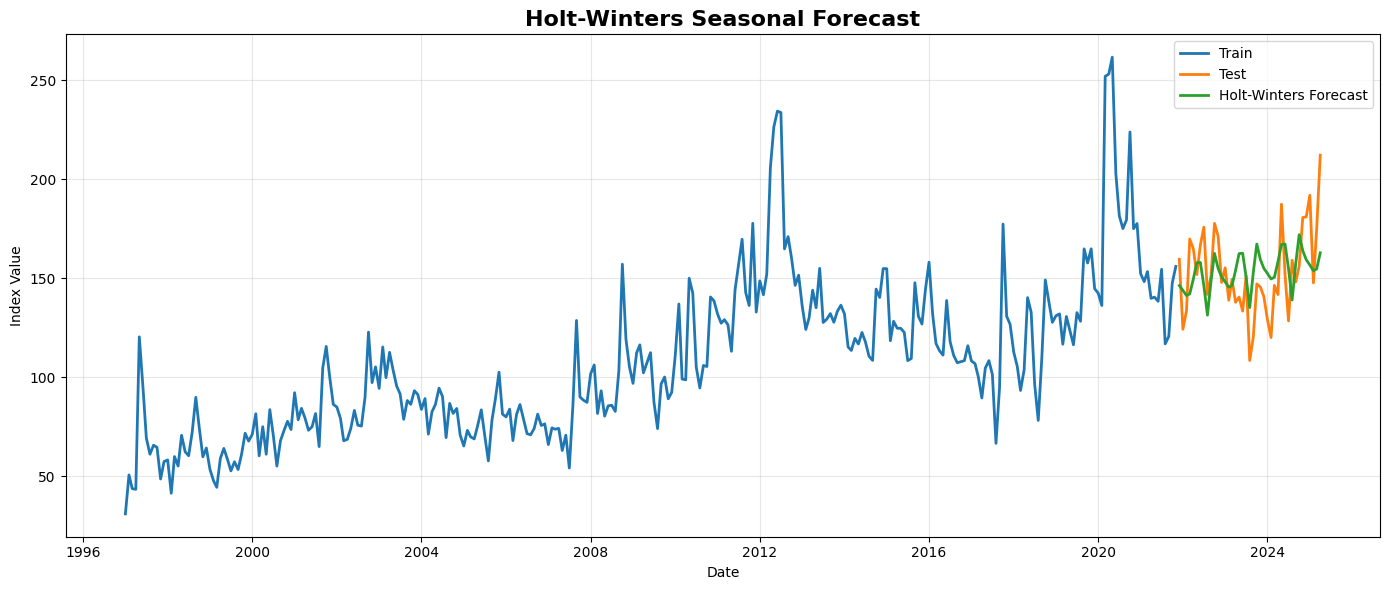

In [977]:
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Train', linewidth=2)
plt.plot(test.index, test, label='Test', linewidth=2)
plt.plot(test.index, hw_forecast, linestyle='-', label='Holt-Winters Forecast', linewidth=2)

plt.title('Holt-Winters Seasonal Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [978]:
mse_hw  = mean_squared_error(test, hw_forecast)
rmse_hw = np.sqrt(mse_hw)
mae_hw  = mean_absolute_error(test, hw_forecast)
mape_hw = np.mean(np.abs((test - hw_forecast) / test)) * 100   # (%)  

print(f"Holt-Winters Test MSE : {mse_hw:.3f}")
print(f"Holt-Winters Test RMSE: {rmse_hw:.3f}")
print(f"Holt-Winters Test MAE : {mae_hw:.3f}")
print(f"Holt-Winters Test MAPE: {mape_hw:.2f}%")


Holt-Winters Test MSE : 394.624
Holt-Winters Test RMSE: 19.865
Holt-Winters Test MAE : 17.028
Holt-Winters Test MAPE: 11.30%


#### 5.3. CLASSICAL TIME SERIES MODELS

##### 5.3.1. ARIMA

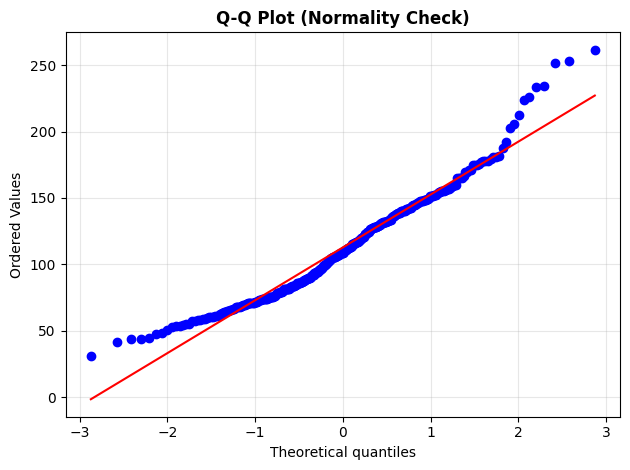

In [982]:
stats.probplot(df['Index value'], dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [983]:
auto_arima_model = pm.auto_arima(
    df["Index value"],
    start_p=0, max_p=5,         
    d=1,                        
    start_q=0, max_q=5,        
    seasonal=False,          
    information_criterion='aic',
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)


print(auto_arima_model.summary())
best_order_arima = auto_arima_model.order
print("Best ARIMA order:", best_order_arima)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2996.551, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2989.565, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2978.704, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2994.793, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2951.292, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2949.811, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2972.669, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2951.598, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2951.716, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2950.244, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2960.258, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2953.295, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2949.003, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2950.870, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]          

In [984]:
model_arima = ARIMA(df["Index value"], order=(2, 1, 1))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Index value   No. Observations:                  340
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1470.502
Date:                Mon, 30 Jun 2025   AIC                           2949.003
Time:                        11:14:38   BIC                           2964.307
Sample:                             0   HQIC                          2955.102
                                - 340                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4600      0.085      5.430      0.000       0.294       0.626
ar.L2         -0.1380      0.057     -2.433      0.015      -0.249      -0.027
ma.L1         -0.7556      0.071    -10.702      0.0

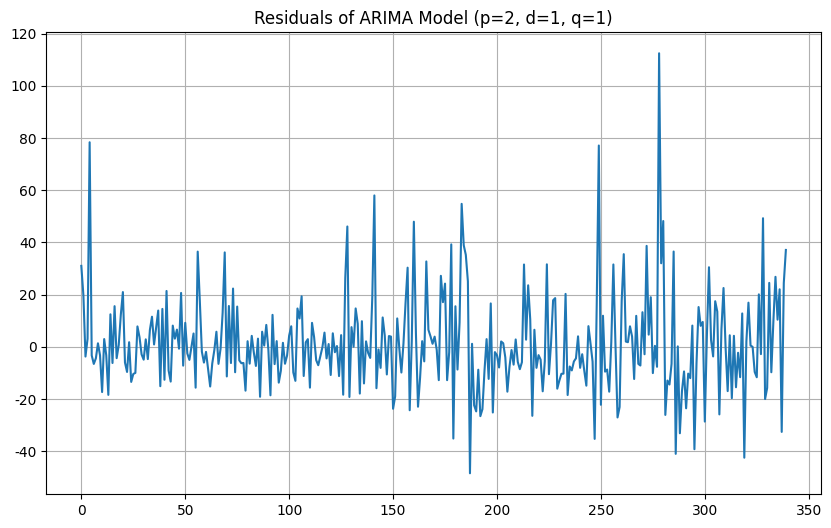

In [985]:
# Residual analysis
residuals = model_arima_fit.resid
plt.figure(figsize=(10, 6))

# Format y-axis
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'{int(x):,}'))

plt.plot(residuals)
plt.title('Residuals of ARIMA Model (p=2, d=1, q=1)')
plt.grid()
plt.show()

Residuals oscillate around zero – this is good, showing the model captured the main trend. However, cannot explain the outliers and volatility

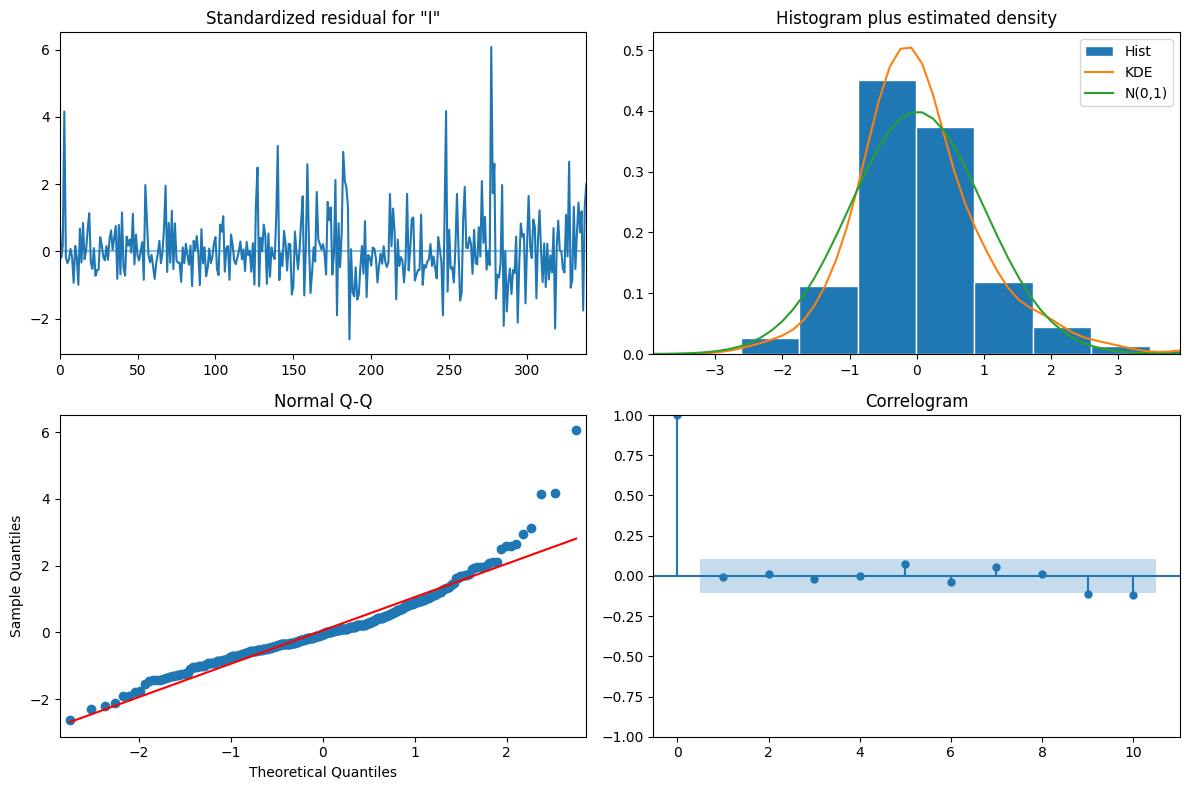

In [987]:
fc = model_arima_fit.get_forecast(steps=12)
y_pred = fc.predicted_mean
conf_int = fc.conf_int()
model_arima_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

Histogram + KDE: approximately normal (mean ~ 0), but with asymmetric tails. <br>
Q-Q plot: slight deviation in the extremes. <br>
Correlogram: lags within confidence intervals -> residuals are approximately white noise.

In [989]:
order = (2, 1, 1)  
y = df["Index value"]
train, test = y.iloc[:-12], y.iloc[-12:]
h = len(test)

In [990]:
model = ARIMA(train, order=order).fit()
y_pred = model.forecast(steps=h)  
y_pred = pd.Series(y_pred.values, index=test.index)

In [991]:
mse_arima  = mean_squared_error(test, y_pred)           
rmse_arima = np.sqrt(mse_arima)                          
mae_arima  = mean_absolute_error(test, y_pred)          
mape_arima = np.mean(np.abs((test - y_pred) / test)) * 100  

print(f"ARIMA Test MSE  : {mse_arima:.3f}")
print(f"ARIMA Test RMSE : {rmse_arima:.3f}")
print(f"ARIMA Test MAE  : {mae_arima:.3f}")
print(f"ARIMA Test MAPE : {mape_arima:.2f}%")

ARIMA Test MSE  : 1450.032
ARIMA Test RMSE : 38.079
ARIMA Test MAE  : 32.199
ARIMA Test MAPE : 17.91%


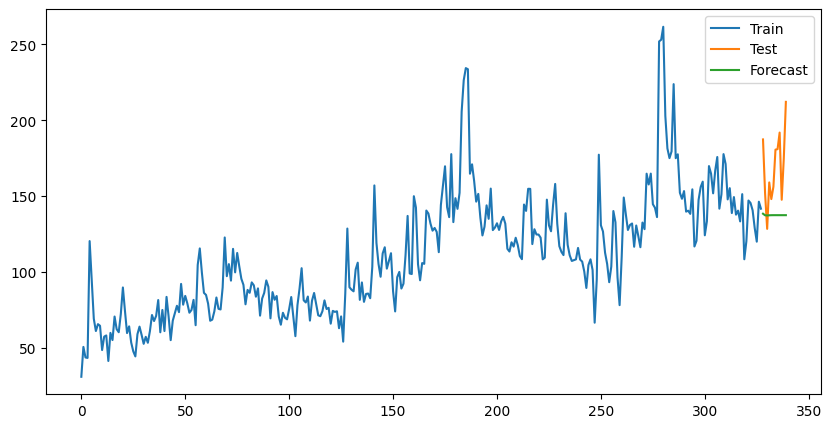

In [992]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test,   label='Test')
plt.plot(y_pred.index, y_pred, label='Forecast')
plt.legend()
plt.show()

 ARIMA handles smooth trends well but struggles with high volatility or structural breaks, ARIMA cleaned the autocorrelation well, but to forecast EPU Index more accurately—especially during volatile periods, hence we should try SARIMA and SARIMAX with exogenous features

##### 5.3.2. SARIMA

To incorporate seasonal effects in time series forecasting, we use the **SARIMA** model (Seasonal ARIMA). Unlike the basic ARIMA, SARIMA adds parameters to capture repeating seasonal patterns. 


In [996]:
auto_sarima_model = pm.auto_arima(
    df["Index value"],
    start_p=0, max_p=5,         
    d=1,                       
    start_q=0, max_q=5,        
    seasonal=True,             
    m=12,                      
    D=1,                      
    start_P=0, max_P=2,        
    start_Q=0, max_Q=2,         
    information_criterion='aic',
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)


print(auto_sarima_model.summary())


best_order_sarima        = auto_sarima_model.order
best_seasonal_order_sarima = auto_sarima_model.seasonal_order
print("Best SARIMA order:", best_order_sarima)
print("Best SARIMA seasonal_order:", best_seasonal_order_sarima)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3056.786, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2962.954, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3042.377, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2935.587, Time=0.42 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.99 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2945.253, Time=0.28 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2923.155, Time=0.55 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=2954.192, Time=0.21 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.83 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=2919.027, Time=0.60 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=2950.091, Time=0.28 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=i

In [997]:
model_sarima = SARIMAX(
    endog=df["Index value"],
    order=(1, 1, 1),
    seasonal_order=(2, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_sarima_fit = model_sarima.fit(disp=False)
print(model_sarima_fit.summary())

# Forecast
h = 12
fc = model_sarima_fit.get_forecast(steps=h)


                                      SARIMAX Results                                      
Dep. Variable:                         Index value   No. Observations:                  340
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1341.031
Date:                             Mon, 30 Jun 2025   AIC                           2692.061
Time:                                     11:15:26   BIC                           2710.614
Sample:                                          0   HQIC                          2699.484
                                             - 340                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7592      0.038     20.010      0.000       0.685       0.834
ma.L1         -1.0000     1

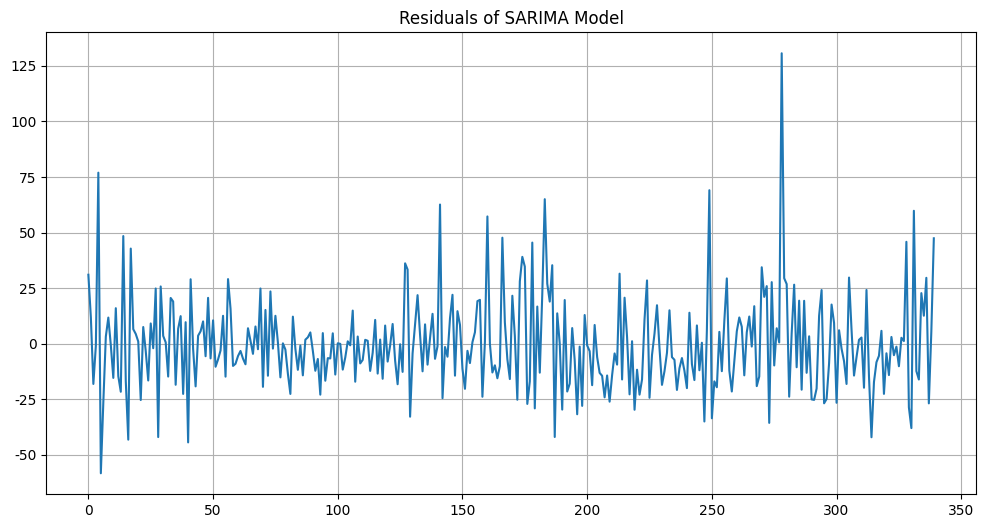

In [998]:
residuals = model_sarima_fit.resid
plt.figure(figsize=(12, 6))

# Format y-axis
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'{int(x):,}'))

plt.plot(residuals)
plt.title('Residuals of SARIMA Model')
plt.grid()
plt.show()

- The model captures much of the underlying structure, but some patterns remain unexplained.
- Residuals are centered around zero, indicating no strong bias.
- Occasional large residuals suggest room for better parameter tuning.

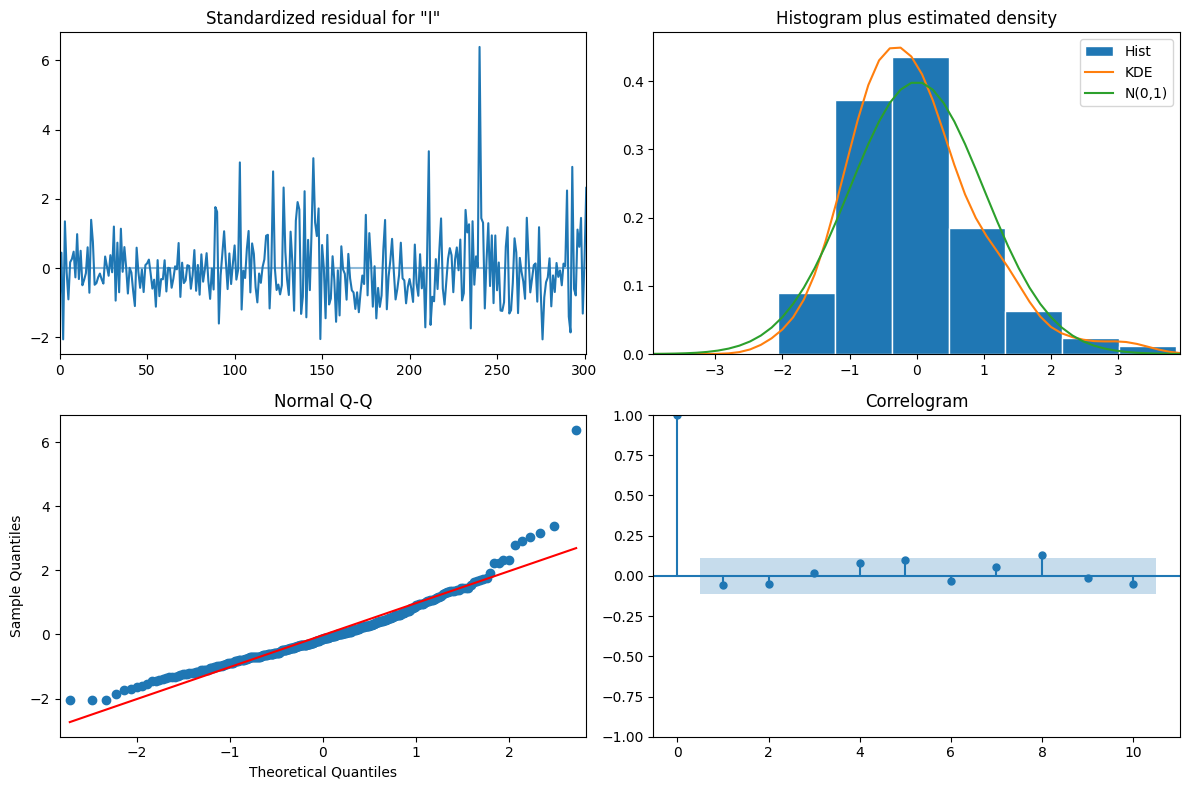

In [1000]:
model_sarima_fit = model_sarima.fit(disp=False)
model_sarima_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

In [1002]:
order          = (1, 1, 1)         
seasonal_order = (2, 1, 0, 12)     
n_test         = 12      

In [1003]:
# y = df["Index value"]
test_size = 12
train = y[:-test_size]
test = y[-test_size:]


In [1004]:
model_sarima = SARIMAX(
    endog          = train,
    order          = order,
    seasonal_order = seasonal_order,
    enforce_stationarity   = False,
    enforce_invertibility  = False
)
res_sarima = model_sarima.fit(disp=False)

In [1005]:
# Forecast
fc     = res_sarima.get_forecast(steps=h)
y_pred = fc.predicted_mean
ci     = fc.conf_int()

In [1006]:
# Align index
y_pred.index = test.index
ci.index     = test.index

# Metrics
mae  = mean_absolute_error(test, y_pred)
rmse = mean_squared_error(test, y_pred)
print(f"SARIMA RMSE = {rmse:.3f}")
print(f"SARIMA MAE  = {mae:.3f}")
print(f"SARIMA MAPE = {mape:.3f}")

SARIMA RMSE = 2032.289
SARIMA MAE  = 40.559
SARIMA MAPE = 10.749


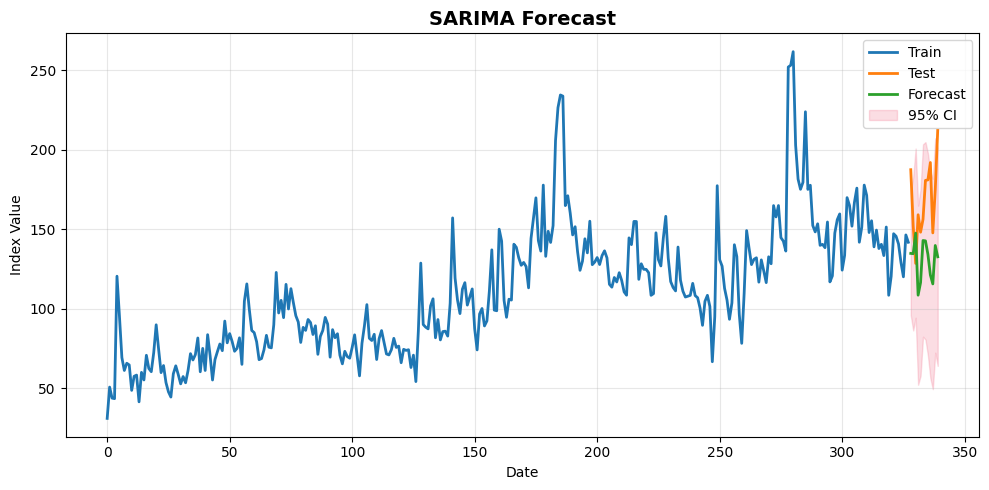

In [1007]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train', linewidth=2)
plt.plot(test.index, test, label='Test', linewidth=2)
plt.plot(y_pred.index, y_pred, label='Forecast', linewidth=2)

plt.fill_between(
    ci.index,
    ci.iloc[:, 0],
    ci.iloc[:, 1],
    color='#ef5675', alpha=0.2,
    label='95% CI'
)

plt.title('SARIMA Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

SARIMA successfully captures seasonal oscillations, outperforming plain ARIMA.
The 95% confidence interval is still wide, indicating room for improvement.
There are periods of under- or over-prediction, especially during sharp changes.

 Hence this model recognizes seasonal structure, but hand-chosen parameters may lead to underfitting.

---

##### 5.3.3. SARIMA OPTIMIZED WITH GRID SEARCH

In [1010]:
test_size = 12
train_data = df['Index value'][:-test_size]
test_data = df['Index value'][-test_size:]

In [1011]:
p = [1, 2, 3]       
d = [1]             
q = [0, 1, 2]        
P = [1, 2, 3]       
D = [1]             
Q = [0, 1]          
m = 12             

In [1012]:
parameter_combinations = list(itertools.product(p, d, q, P, D, Q))

In [1013]:
results = []
for param in parameter_combinations:
    order = (param[0], param[1], param[2])
    seasonal_order = (param[3], param[4], param[5], m)
    try:
        model = SARIMAX(df["Index value"],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        res = model.fit(disp=False)
   
        results.append((order, seasonal_order, res.aic))
        print(f"Tested SARIMAX{order} x {seasonal_order} → AIC={res.aic:.2f}")
    except Exception:
        continue

Tested SARIMAX(1, 1, 0) x (1, 1, 0, 12) → AIC=2843.51
Tested SARIMAX(1, 1, 0) x (1, 1, 1, 12) → AIC=2763.71
Tested SARIMAX(1, 1, 0) x (2, 1, 0, 12) → AIC=2712.78
Tested SARIMAX(1, 1, 0) x (2, 1, 1, 12) → AIC=2661.79
Tested SARIMAX(1, 1, 0) x (3, 1, 0, 12) → AIC=2595.92
Tested SARIMAX(1, 1, 0) x (3, 1, 1, 12) → AIC=2564.32
Tested SARIMAX(1, 1, 1) x (1, 1, 0, 12) → AIC=2821.30
Tested SARIMAX(1, 1, 1) x (1, 1, 1, 12) → AIC=2738.30
Tested SARIMAX(1, 1, 1) x (2, 1, 0, 12) → AIC=2692.06
Tested SARIMAX(1, 1, 1) x (2, 1, 1, 12) → AIC=2637.60
Tested SARIMAX(1, 1, 1) x (3, 1, 0, 12) → AIC=2576.10
Tested SARIMAX(1, 1, 1) x (3, 1, 1, 12) → AIC=2541.47
Tested SARIMAX(1, 1, 2) x (1, 1, 0, 12) → AIC=2819.98
Tested SARIMAX(1, 1, 2) x (1, 1, 1, 12) → AIC=2724.16
Tested SARIMAX(1, 1, 2) x (2, 1, 0, 12) → AIC=2693.09
Tested SARIMAX(1, 1, 2) x (2, 1, 1, 12) → AIC=2639.08
Tested SARIMAX(1, 1, 2) x (3, 1, 0, 12) → AIC=2574.14
Tested SARIMAX(1, 1, 2) x (3, 1, 1, 12) → AIC=2542.60
Tested SARIMAX(2, 1, 0) x (1

In [1014]:
best_order, best_seasonal_order, best_aic = sorted(results, key=lambda x: x[2])[0]
print(f"Best order          = {best_order}")
print(f"Best seasonal_order = {best_seasonal_order}")
print(f"Best AIC            = {best_aic:.2f}")



Best order          = (3, 1, 1)
Best seasonal_order = (3, 1, 1, 12)
Best AIC            = 2529.45


In [1015]:
final_model = SARIMAX(
    df['Index value'],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
# Fit the model using the Powell optimization method to avoid convergence error
optimized_fit = final_model.fit(disp=False, method='powell')
print(optimized_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        Index value   No. Observations:                  340
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood               -1255.347
Date:                            Mon, 30 Jun 2025   AIC                           2528.694
Time:                                    11:18:13   BIC                           2561.660
Sample:                                         0   HQIC                          2541.905
                                            - 340                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2783      0.194      1.435      0.151      -0.102       0.658
ar.L2         -0.1259      0.073   

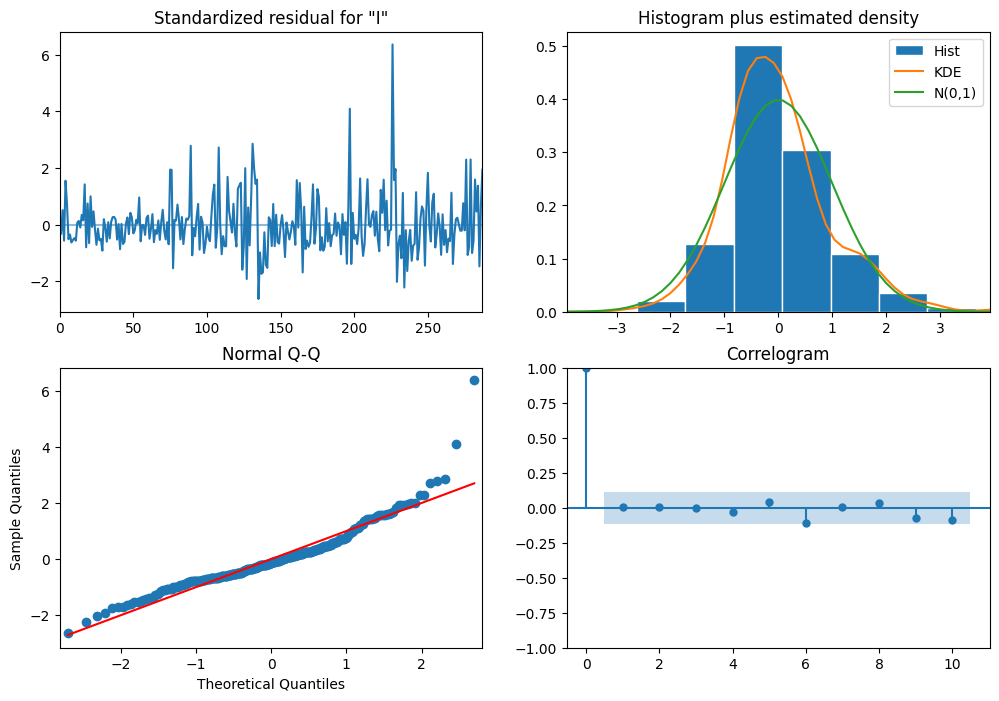

In [1016]:
optimized_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [1017]:
forecast = optimized_fit.get_forecast(steps=test_size)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Đảm bảo index đúng để so sánh/plot
forecast_mean.index = test_data.index
forecast_ci.index = test_data.index

In [1018]:
# Evaluate model performance
mae = mean_absolute_error(test_data, forecast_mean)
rmse = np.sqrt(mean_squared_error(test_data, forecast_mean))
mape = np.mean(np.abs((test_data - forecast_mean) / test_data)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 27.70
Root Mean Squared Error (RMSE): 32.26
Mean Absolute Percentage Error (MAPE): 17.90%


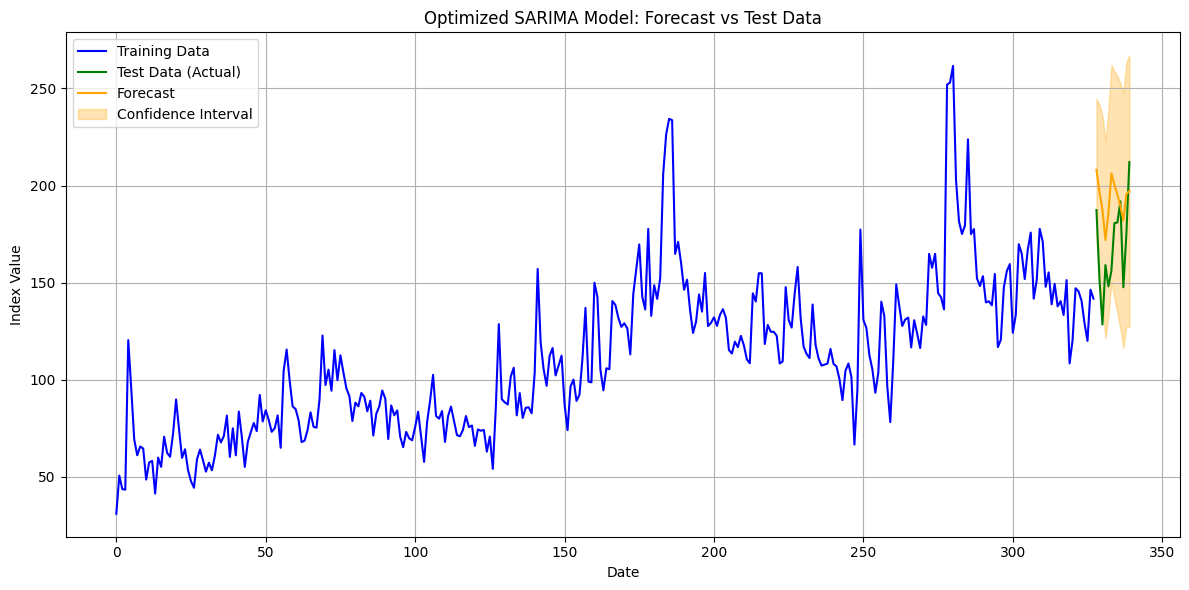

In [1019]:
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data', color='blue')
plt.plot(test_data, label='Test Data (Actual)', color='green')
plt.plot(test_data.index, forecast_mean, label='Forecast', color='orange')
plt.fill_between(test_data.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.3, label='Confidence Interval')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title('Optimized SARIMA Model: Forecast vs Test Data')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

##### 5.5.4. SARIMAX

In [1021]:
endog = fe_df['Index value']
exog  = fe_df.drop(columns=['Date', 'Index value']).replace([np.inf, -np.inf], np.nan)

data_combined = pd.concat([endog, exog], axis=1).dropna()
endog_clean   = data_combined['Index value']
exog_clean    = data_combined.drop(columns=['Index value'])


In [1022]:
n = len(endog_clean)
split = int(n * 0.88) 

y_train, y_test = endog_clean.iloc[:split], endog_clean.iloc[split:]
exog_train, exog_test = exog_clean.iloc[:split], exog_clean.iloc[split:]


In [1023]:
model_sarimax_find = pm.auto_arima(
    y_train, exogenous=exog_train,
    start_p=0, max_p=5, start_q=0, max_q=5,
    d=None, seasonal=True, m=12,
    start_P=0, max_P=2, start_Q=0, max_Q=2, D=None,
    trace=True, stepwise=True, information_criterion='aic',
    error_action='ignore', suppress_warnings=True
)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2518.402, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2512.581, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2507.942, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2516.498, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2509.664, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2508.685, Time=0.61 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2507.431, Time=0.16 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=2507.469, Time=0.36 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2517.583, Time=0.26 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2484.678, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2485.008, Time=0.09 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=2486.011, Time=0.78 sec
 ARIMA(1,1,1)(1,0,1)[12] inte

In [1024]:
best_order, best_seasonal = model_sarimax_find.order, model_sarimax_find.seasonal_order
print("Best order:", best_order, "  Best seasonal:", best_seasonal)

Best order: (1, 1, 1)   Best seasonal: (1, 0, 0, 12)


In [1025]:
sarimax = SARIMAX(
    y_train, exog=exog_train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)
result_sarimax = sarimax.fit(disp=False)
print(result_sarimax.summary())


                                      SARIMAX Results                                      
Dep. Variable:                         Index value   No. Observations:                  288
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood               -1153.064
Date:                             Mon, 30 Jun 2025   AIC                           2354.127
Time:                                     11:18:31   BIC                           2440.842
Sample:                                          0   HQIC                          2388.933
                                             - 288                                         
Covariance Type:                               opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Month            0.1948      0.389      0.500      0.617      -0.569       0.958
month            0.19

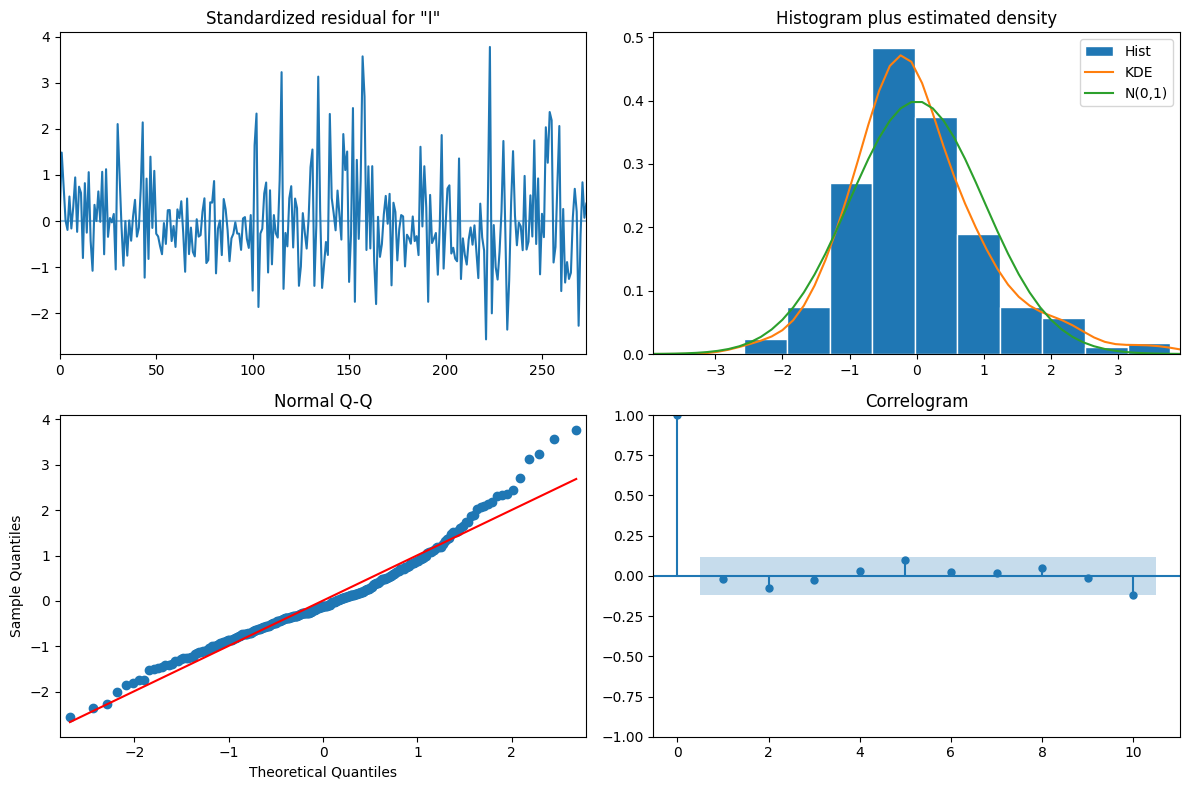

In [1026]:
result_sarimax.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

In [1027]:
h = len(y_test)
fc = result_sarimax.get_forecast(steps=h, exog=exog_test)
pred_mean = fc.predicted_mean
conf_int = fc.conf_int()
pred_mean.index = y_test.index
conf_int.index = y_test.index


In [1028]:
mae = mean_absolute_error(y_test, pred_mean)
mse = mean_squared_error(y_test, pred_mean)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, pred_mean)

print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"MAPE : {mape:.3%}")

MAE  : 30.855
RMSE : 38.260
MSE  : 1463.808
MAPE : 22.098%


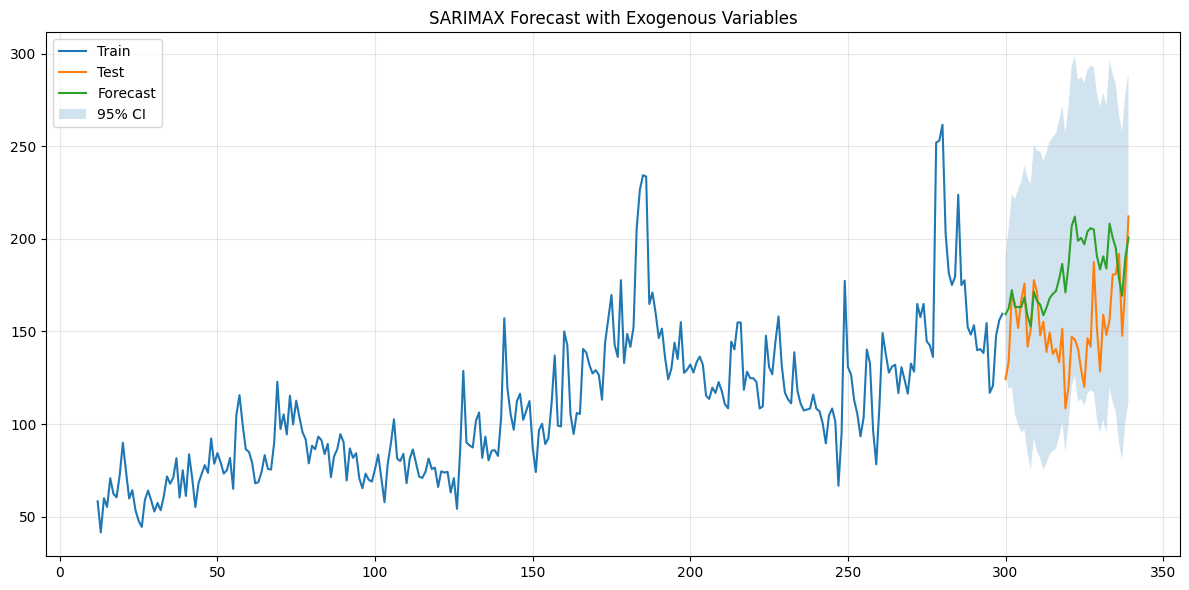

In [1029]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(pred_mean.index, pred_mean, label='Forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2, label='95% CI')
plt.legend()
plt.title('SARIMAX Forecast with Exogenous Variables')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


##### 5.3.5. ARCH & GARCH

In [1031]:
df = df.reset_index()

In [1032]:
returns = df[['Date', 'Index value']].copy()
returns['y'] = returns['Index value'].pct_change().dropna()
returns = returns.dropna()[['Date', 'y']].rename(columns={'Date': 'ds'}); returns
returns['unique_id'] = 'epu index'
returns

,ds,y,unique_id
1,1997-02-01,0.634367,epu index
2,1997-03-01,-0.136911,epu index
3,1997-04-01,-0.007462,epu index
4,1997-05-01,1.772732,epu index
5,1997-06-01,-0.207043,epu index
...,...,...,...
335,2024-12-01,0.001676,epu index
336,2025-01-01,0.060401,epu index
337,2025-02-01,-0.230619,epu index
338,2025-03-01,0.184354,epu index


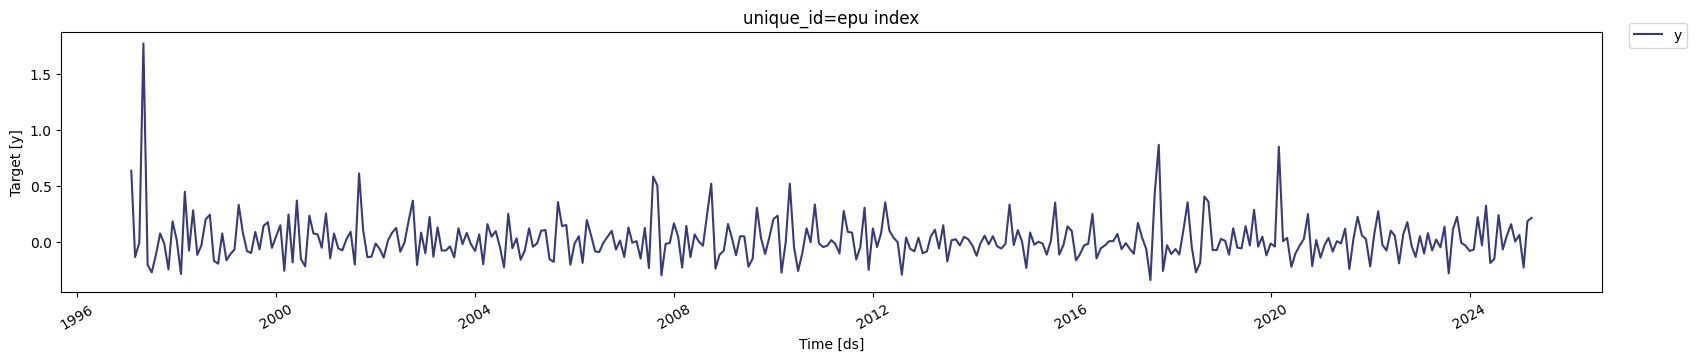

In [1033]:
StatsForecast.plot(
    df=returns
)

In [1034]:
y = df['Index value'].pct_change().dropna()
y = y * 100  

p_list = [1, 2, 3]      
q_list = [0, 1, 2]    
best = {'type':None, 'order':None, 'aic':np.inf}

for p in p_list:
    try:
        m = arch_model(y, mean='Constant', vol='ARCH', p=p, o=0, q=0, dist='normal')
        res = m.fit(disp='off')
        print(f"ARCH({p}) → AIC={res.aic:.2f}")
        if res.aic < best['aic']:
            best.update({'type':'ARCH', 'order':(p,), 'aic':res.aic})
    except Exception as e:
        print(f"  ARCH({p}) failed:", e)

for p, q in itertools.product(p_list, q_list):
    if q == 0: 
        continue  
    try:
        m = arch_model(y, mean='Constant', vol='GARCH', p=p, o=0, q=q, dist='normal')
        res = m.fit(disp='off')
        print(f"GARCH({p},{q}) → AIC={res.aic:.2f}")
        if res.aic < best['aic']:
            best.update({'type':'GARCH', 'order':(p,q), 'aic':res.aic})
    except Exception as e:
        print(f"  GARCH({p},{q}) failed:", e)

if best['type'] is not None:
    print("\n==> Best model:")
    print(f"  Type   : {best['type']}")
    print(f"  Order  : {best['order']}")
    print(f"  AIC    : {best['aic']:.2f}")
else:
    print("Cannot find best model, please check again p/q.")


ARCH(1) → AIC=2999.80
ARCH(2) → AIC=3000.79
ARCH(3) → AIC=2943.93
GARCH(1,1) → AIC=2939.89
GARCH(1,2) → AIC=2939.63
GARCH(2,1) → AIC=2941.89
GARCH(2,2) → AIC=2941.63
GARCH(3,1) → AIC=2943.89
GARCH(3,2) → AIC=2943.63

==> Best model:
  Type   : GARCH
  Order  : (1, 2)
  AIC    : 2939.63


In [1035]:
models = [
    ARCH(1),
    GARCH(1,1),
    GARCH(1,2),
]

sf = StatsForecast(models=models, freq='MS', n_jobs=-1)

cv_df = sf.cross_validation(
    df        = returns,
    h         = 12,
    step_size = 12,
    n_windows = 4
)


In [1036]:
cv_df.rename(columns = {'y' : 'actual'}, inplace = True)
cv_df.head()

,unique_id,ds,cutoff,actual,ARCH(1),"GARCH(1,1)","GARCH(1,2)"
0,epu index,2021-05-01,2021-04-01,0.004400,0.327294,0.258311,0.326634
1,epu index,2021-06-01,2021-04-01,-0.014939,-0.134054,-0.119999,-0.135038
2,epu index,2021-07-01,2021-04-01,0.116784,-0.107414,-0.098487,-0.107582
3,epu index,2021-08-01,2021-04-01,-0.243733,-0.216938,-0.190016,-0.216689
4,epu index,2021-09-01,2021-04-01,0.032200,0.180562,0.162536,0.180976


This returns series is also get some volatility, so we need to use ARCH/GARCH model to forecast the volatility.

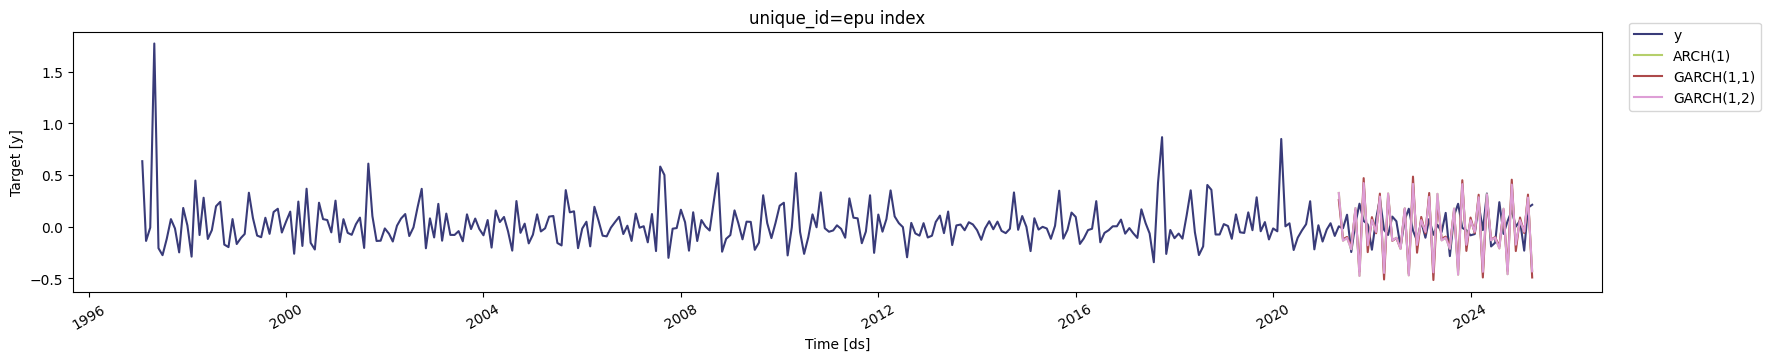

In [1038]:
StatsForecast.plot(returns, cv_df.drop(['cutoff', 'actual'], axis=1))


In [1039]:
model_cols = [col for col in cv_df.columns if col not in ['unique_id', 'ds', 'cutoff', 'actual']]

metrics = []
for model in model_cols:
    y_true = cv_df['actual']
    y_pred = cv_df[model]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true) * 100).mean()
    metrics.append({
        'Model': model,
        'RMSE': mse,
        'MAE': mae,
        'MAPE (%)': mape
    })

metrics_df = pd.DataFrame(metrics).set_index('Model')
print(metrics_df)

                   RMSE       MAE    MAPE (%)
Model                                        
ARCH(1)     1463.807786  0.227908  757.878094
GARCH(1,1)  1463.807786  0.241640  834.143980
GARCH(1,2)  1463.807786  0.228979  764.556452
